# Module Imports

In [1]:
import json
import matplotlib.pyplot as plt
import mne
import neurokit2 as nk
import nibabel as nb
import numpy as np
import pandas as pd
import pickle
import warnings

from cca_zoo.linear import MCCA
from dcor import rowwise, distance_correlation
from matplotlib import cm, gridspec, colors
from matplotlib.lines import Line2D
from matplotlib.patches import ConnectionPatch
from mne.time_frequency import tfr_array_morlet, tfr_multitaper, tfr_morlet
from nilearn import plotting
from nilearn.image import index_img
from patsy import dmatrix
from scipy.io import loadmat
from scipy.signal import welch, csd, resample
from scipy.interpolate import interp1d
from scipy.stats import zscore
from sklearn.linear_model import LinearRegression
from utils.deconv_gp import deconv_gp
from utils.glm_utils import construct_task_blocks, onsets_to_block, xcorr
from utils.load_write import (
    convert_2d, convert_4d,
    load_subject_list, load_chang_bh_event_file,
    load_chang_cue_event_file, load_nki_event_file
)
from utils.notebook_utils import lag_basis, load_pca_results, load_subj


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


# 1. Data Load

This section defines global variables for handing and visualing datasets, as well as loading the  PCA time courses from the 'run_pca.py' script (see below). Our analyses focus on the first principal component (PC1) that approximates the 'global signal', but one can adapt this code for analysis of any sort of signals derived from the functional MRI scans.

## 1.1 Choose Datasets and Define Global Variables

In [2]:
# choose datasets
datasets = [
    'chang', 
    'chang_bh', 
    'chang_cue', 
    'hcp', 
    'natview', 
    'nki', 
    'nki_rest', 
    'spreng',
    'yale'
]

# Label dictionary (as labeled in the manuscript)
dataset_label_dict = {
    'chang': 'ME-REST',
    'chang_bh': 'ME-TASK',
    'hcp': 'HCP-REST',
    'natview': 'NATVIEW-REST',
    'nki': 'NKI-TASK',
    'nki_rest': 'NKI-REST',
    'spreng': 'ME-REST-SUPP',
    'toronto': 'TORONTO-REST',
    'yale': 'YALE-REST'
}

# Physio variable to label dictionary
physio_label_dict = {
    'PPG_HR': 'Heart Rate',
    'ECG_HR': 'Heart Rate',
    'PPG_LOW': 'PPG Low-Freq',
    'PPG_PEAK_AMP': 'PPG Amplitude',
    'RSP_RVT': 'Resp Volume',
    'GSR': 'Skin Conductance',
    'PUPIL': 'Pupil Diameter',
    'PC1': 'PC1',
    'ALPHA': 'Alpha EEG'
}

# Physio label colormaps
physio_cmap_b = plt.get_cmap('tab20b')
physio_cmap_c = plt.get_cmap('tab20c')
color_dict = {
    'PC1': physio_cmap_c(0),
    'PPG_HR': physio_cmap_b(4),
    'PPG_PEAK_AMP': physio_cmap_b(12),
    'PPG_LOW': physio_cmap_b(0),
    'ALPHA': physio_cmap_b(9),
    'GSR': physio_cmap_c(4),
    'RSP_RVT': physio_cmap_c(16),
    'PUPIL': physio_cmap_b(16)
}

# physio shading for different datasets
d_color_dict = {
    'PPG_HR': {
        'chang': physio_cmap_b(4),
        'hcp': physio_cmap_b(5),
        'spreng': physio_cmap_b(6),
        'nki_rest': physio_cmap_b(7)
    },
    'PPG_PEAK_AMP': {
        'chang': physio_cmap_b(12),
        'hcp': physio_cmap_b(13),
        'spreng': physio_cmap_b(14),
        'nki_rest': physio_cmap_b(15)
    },
    'PPG_LOW': {
        'chang': physio_cmap_b(0),
        'hcp': physio_cmap_b(1),
        'spreng': physio_cmap_b(2),
        'nki_rest': physio_cmap_b(3)
    },
    'ALPHA': {
        'chang': physio_cmap_b(9),
        'natview': physio_cmap_b(10)
    },
    'GSR': {
        'nki_rest': physio_cmap_c(4)
    },
    'RSP_RVT': {
        'chang': physio_cmap_c(16),
        'hcp': physio_cmap_c(17),
        'spreng': physio_cmap_c(18),
        'nki_rest': physio_cmap_c(19)
    },
    'PUPIL': {
        'yale': physio_cmap_b(16),
        'natview': physio_cmap_b(17)
    }
}


## 1.2. Load PCA Time Courses

PCA results for each dataset are produced by the 'run_pca.py' script in the base directory. By default the runner script ('run_all.py') saves the results as pickle (.pkl) files to the following file path 'results/pca'. If you put the PCA results in another directory, please change the file path below via the *pca_dir* variable. 

PCA is applied to the group-wise temporally concatenated BOLD time courses. Thus, the PC time courses must be 'de-concatenated' and assigned to each subject based on the order of the subjects concatenated in the 'run_pca.py' script. This is accomplished by both the order of the subjects in the concatenation and the length of the functional scan for each subject (in most cases, the length is identical across subjects). This order is determined based on the order of the subjects in the subject list .csv in each dataset directory (e.g. 'data/dataset_chang/subject_list_chang.csv'). If a dataset's subject list .csv file are manipulated (e.g. subject removed, re-ordered) **after** you run PCA via the 'run_pca.py', you should assume that the order is compromised, and that the PCA time courses produced from the code below are corrupted. Basically, if you change the subject file .csv for a dataset, re-run the 'run_pca.py' script before running the code below.

In [3]:
# load in dataset parameters
params = json.load(open('analysis_params.json', 'rb'))

# specify directory to pca results
pca_dir = 'results/pca'

# load pca time courses
pca_dict = {}
for d in datasets:
    pca_fp = f'{pca_dir}/{d}_pca_results.pkl'
    pca_dict[d] = load_pca_results(d, pca_fp, params[d])

## 1.3 Set Sign of First Principal Component

PCA dimensions suffer from a well-known sign-ambiguity, such that flipping the sign of the principal components represents an equally valid solution. This is problematic when comparing PCA solutions across datasets. For this study, we ensure that the distributed spatial weights of the first PC are positive across the gray matter. In datasets where the spatial weights are negative across the cortex, we sign-flip them to ensure all datasets are consistent. In principle, the code below should not need to be changed if the exact preprocessing and subjects are used as our study. But it is worth checking the PCA nifti output ('.nii' files) to ensure.

In [4]:
pca_sign_dict = {
    'chang': -1, 
    'chang_bh': 1, 
    'chang_cue': 1,
    'hcp': 1, 
    'natview': -1, 
    'nki': -1, 
    'nki_rest': 1,
    'spreng': -1,
    'toronto': -1,
    'yale': -1
}

# 2. Cross-Correlations

## 2.1 Physio Cross-Correlations

Text(0.5, 1.0, 'Pupil Diameter')

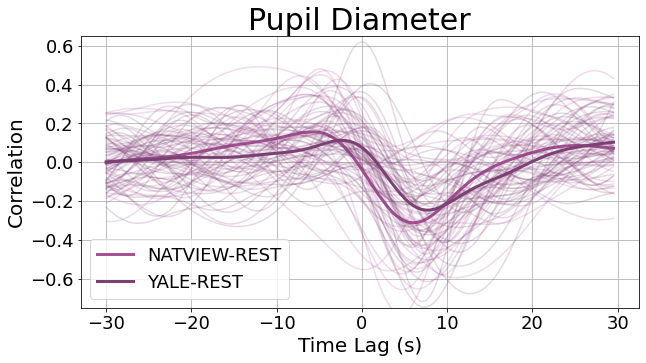

In [5]:
## Choose:
# Electrophysio Signals: PPG_LOW, RSP_RVT, PPG_HR, PPG_PEAK_AMP, ALPHA, PUPIL, GSR
e_signal = 'PUPIL'

# datasets: 'chang', 'hcp', 'natview', 'nki_rest', 'spreng', 'yale'
datasets_cc = ['natview', 'yale']

# pca index (0 - corresponds to first principal component)
pca_index = 0

# select time series similarity function ('correlation' or 'distance_correlation')
corr_func = 'correlation'

# set permutation parameters
permute=False
n_perm=500

# Max number of samples to display in cross-correlation plot
n_max = 50

fig, ax = plt.subplots(1,1, figsize=(10,5))

# Inperpolation parameters
x_interp = np.arange(-30, 30, 0.5)
# specify length of cross-correlation function based on TR.
# we try to get around 30s 
cc_len_dict = {d: np.ceil(30/params[d]['tr']).astype(int)
               for d in datasets_cc}

# specify pca label from PC index
pca_label = f"PC{pca_index+1}"

# Create permutations
if permute:
    permute_cc = {d: [] for d in datasets_cc}
    
# create time series similarity function
if corr_func == 'correlation':
    def ts_sim(x,y,maxlag):
        return xcorr(x, y, maxlags=maxlag)
elif corr_func == 'distance_correlation':
    def ts_sim(x,y, maxlag):
        lag_array = np.arange(-maxlag,maxlag+1)[::-1]
        x_shift = [np.roll(x, i) for i in lag_array]
        y_copy = [y for i in lag_array]
        cc = rowwise(distance_correlation, x_shift, y_copy)
        return lag_array[::-1], cc
    
# Loop through datasets and calculate cross-correlations
for d in datasets_cc:
    interp_cc = []
    # get subject list
    subject, scan = load_subject_list(d, params[d]['subject_list'])
    # loop through subjects and cross-correlate physio with PC time course
    for subj, sc in zip(subject, scan):
        # Load subject data
        df = load_subj(subj, sc, d, params[d], pca_dict[d][f'{subj}_{sc}'], 
                       pca_index=pca_index)
        # flip sign for PC1, if necessary
        if pca_index == 0:
            df['PC1'] = df['PC1'] * pca_sign_dict[d]
        # Compute cross-correlation
        cc_list = ts_sim(df[pca_label].values, df[e_signal].values, cc_len_dict[d])
        f_interp = interp1d(cc_list[0]*(params[d]['tr']), cc_list[1], kind='cubic')
        interp_cc.append(f_interp(x_interp))
        # Create permutation distribution, if specified
        if permute:
            permute_subj_cc = []
            for p in range(n_perm):
                # Supress divide by invalid value warning
                with warnings.catch_warnings():
                    warnings.filterwarnings("ignore", message="invalid value encountered in true_divide")
                    surrogate = nk.signal_surrogate(df[e_signal].values, method='IAAFT', 
                                                    max_iter=100, atol=1e-5, rtol=1e-6)
                _, cc = ts_sim(df[pca_label].values, surrogate, cc_len_dict[d])
                permute_subj_cc.append(cc)
            permute_cc[d].append(np.vstack(permute_subj_cc))
    ax.plot(x_interp, np.mean(interp_cc, axis=0), linewidth=3, 
            color=d_color_dict[e_signal][d], label=dataset_label_dict[d])
    interp_cc_sample = interp_cc[:n_max]
    ax.plot(x_interp, np.array(interp_cc_sample).T, 
            color=d_color_dict[e_signal][d], alpha=0.2)

ax.grid(True)
ax.legend(fontsize=18)
ax.tick_params(axis='both', which='major', labelsize=18)
ax.set_xlabel('Time Lag (s)', fontsize=20)
if corr_func == 'correlation':
    ax.set_ylim([-0.75, 0.65])
    ax.set_ylabel('Correlation', fontsize=20)
elif corr_func == 'distance_correlation':
    ax.set_ylim([0, 0.65])
    ax.set_ylabel('Distance Correlation', fontsize=20)

if permute:
    for d in datasets_cc:
        perm_concat = np.stack(permute_cc[d], axis=2)
        perm_avg = np.abs(np.mean(perm_concat, axis=2))
        p_05 = np.quantile(perm_avg, 0.95)
        if corr_func == 'correlation':
            ax.axhline(p_05, 0, 1, color=d_color_dict[e_signal][d], 
                       alpha=0.5, linestyle = '--')
            ax.axhline(-p_05, 0, 1, color=d_color_dict[e_signal][d], 
                       alpha=0.5, linestyle = '--')
        elif corr_func == 'distance_correlation':
            ax.axhline(p_05, 0, 1, color=d_color_dict[e_signal][d], 
                       alpha=0.7, linestyle = '--')
ax.set_title(f"{physio_label_dict[e_signal]}", fontsize=30)
# plt.savefig(f"{physio_label_dict[e_signal]}.png", bbox_inches='tight')

## 2.2 EEG Power Cross-Correlations

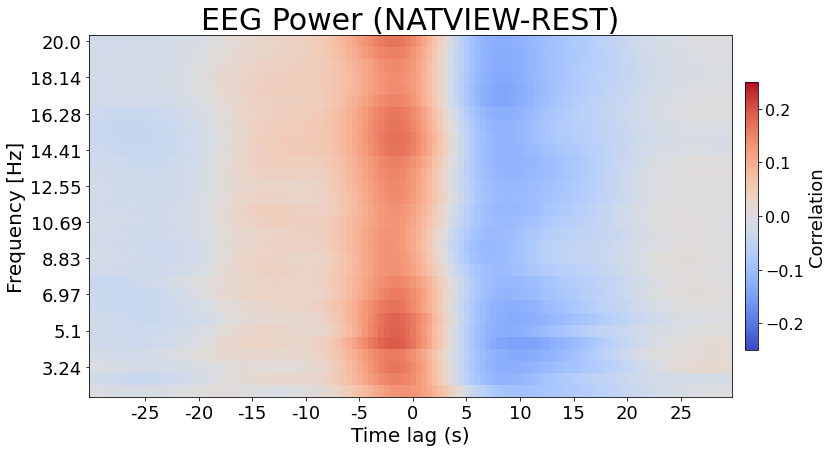

In [6]:
# choose dataset - natview, chang
dataset_power = 'natview'

# pca index (0 - corresponds to first principal component)
pca_index = 0

# Select frequencies (2 to 20 Hz)
freqs = np.linspace(2, 20, 30)[::-1]

# interpolation time points for smooth cross-corr estimation
x_interp = np.arange(-30, 30, 0.5)

# specify pca label from PC index
pca_label = f"PC{pca_index+1}"

# Loop through subjects and compute cross-correlations
subject, scan = load_subject_list(dataset_power, params[dataset_power]['subject_list'])
xcorr_results = []
for subj, sc in zip(subject, scan):
    # load subject dataframe with PC time course
    df = load_subj(subj, sc, dataset_power, params[dataset_power], 
                   pca_dict[dataset_power][f'{subj}_{sc}'], pca_index=pca_index)
    # flip sign for PC1, if necessary
    if pca_index == 0:
        df['PC1'] = df['PC1'] * pca_sign_dict[dataset_power]
    raw = mne.io.read_raw_fif(params[dataset_power]['eeg'].format(subj, sc), 
                              preload=True, verbose=False)
    func_len = nb.load(params[dataset_power]['func'].format(subj, sc)).shape[-1]
    # set n_cycle parameter for wavelet (> cycles, > frequency resolution & < time resolution)
    n_cycles = 15
    # Commented out multitaper power estimation approach
    # time_bandwidth = 4.0  
    # power = tfr_multitaper(epochs, freqs=freqs, n_cycles=n_cycles,
    #                        time_bandwidth=time_bandwidth, return_itc=False, 
    #                        average=True)
    # Grab parameters
    times = raw.times; sfreq = raw.info['sfreq']
    # Get data into numpy array
    raw_data = raw.get_data()[np.newaxis,:]
    # Morlet time-frequency power estimation
    power = tfr_array_morlet(raw_data, sfreq, freqs, n_cycles=n_cycles, output='power', 
                             verbose=False)
    power_avg = np.squeeze(power).mean(axis=0)
    # loop through frequencies and calculate cross-correlation with PC time course
    xcorr_subj = []
    for i in range(len(freqs)):
        resample_freq = nk.signal_resample(power_avg[i,:], desired_length=func_len, 
                                           method='FFT')
        cc_list = ts_sim(df[pca_label].values, resample_freq, maxlag=20)
        f_interp = interp1d(cc_list[0]*(params[dataset_power]['tr']), 
                            cc_list[1], kind='cubic')
        xcorr_subj.append(f_interp(x_interp))
    xcorr_results.append(np.vstack(xcorr_subj))  

# Plot
fig, ax = plt.subplots(figsize=(12,10))
xcorr_avg = np.stack(xcorr_results, axis=2).mean(axis=2)
if corr_func == 'correlation':
    cbar_label = 'Correlation'
    vmin, vmax = -0.25, 0.25
elif corr_func == 'distance_correlation':
    cbar_label = 'Distance Correlation'
    vmin, vmax = 0, 0.25
im = ax.imshow(xcorr_avg, cmap='coolwarm', vmin=-0.25, vmax=0.25, aspect=2.25)
freq_sample = np.arange(0,len(freqs),3)
ax.set_yticks(freq_sample)
ax.set_yticklabels(np.round(freqs[freq_sample],2), fontsize=18)
ax.set_ylabel('Frequency [Hz]', fontsize=20)
x_sample = np.arange(0,len(x_interp), 10)
ax.set_xticks(x_sample)
ax.set_xticklabels(x_interp[x_sample].astype(int), fontsize=18)
ax.set_xlabel('Time lag (s)', fontsize=20)
xticks = ax.xaxis.get_major_ticks()
xticks[0].set_visible(False)
cbar = plt.colorbar(im,fraction=0.02, pad=0.02)
cbar.ax.tick_params(labelsize=16)
cbar.set_label(cbar_label, fontsize=18)
ax.set_title(f"EEG Power ({dataset_label_dict[dataset_power]})", 
             fontsize=30)
plt.show()
# plt.savefig(f"EEG_POWER_{dataset_label_dict[dataset_power]}.png", bbox_inches='tight')

# 3. Joint Co-Fluctuations - MCCA

## 3.1 Dataset Physio Selections

In [6]:
# choose vars for MCCA for each dataset
mcca_vars = {
    'chang': ['PC1', 'RSP_RVT', 'PPG_HR', 'PPG_LOW', 'PPG_PEAK_AMP', 'ALPHA'],
    'hcp': ['PC1', 'RSP_RVT', 'PPG_HR', 'PPG_LOW', 'PPG_PEAK_AMP'],
    'natview': ['PC1', 'PUPIL', 'ALPHA'],
    'nki_rest': ['PC1', 'RSP_RVT', 'PPG_HR', 'PPG_LOW', 'PPG_PEAK_AMP', 'GSR'],
    'spreng': ['PC1', 'RSP_RVT', 'PPG_HR', 'PPG_LOW', 'PPG_PEAK_AMP']
}

# set lags for each dataset - ~15s for each dataset
lag_n = {
    'chang': 7,
    'hcp': 20,
    'nki_rest': 11,
    'natview': 7,
    'spreng': 5
}

# set sign of physio CCA sets for consistency across datasets
cca_sign_dict = {
    'chang': {
        'PC1': 1,
        'RSP_RVT': 1,
        'PPG_HR': 1,
        'PPG_LOW': 1,
        'PPG_PEAK_AMP': 1,
        'ALPHA': 1
    },
    'hcp': {
        'PC1': -1,
        'RSP_RVT': 1,
        'PPG_HR': 1,
        'PPG_LOW': 1,
        'PPG_PEAK_AMP': 1
    },
    'natview': {
        'PC1': 1,
        'PUPIL': 1,
        'ALPHA': 1
    },
    'nki_rest': {
        'PC1': -1,
        'RSP_RVT': 1,
        'PPG_HR': 1,
        'PPG_LOW': 1,
        'PPG_PEAK_AMP': 1,
        'GSR': 1
    },
    'spreng': {
        'PC1': 1,
        'RSP_RVT': 1,
        'PPG_HR': 1,
        'PPG_LOW': 1,
        'PPG_PEAK_AMP': 1
    }
}

## 3.2 Multi-Set CCA

Text(0.5, 1.0, 'NATVIEW-REST (r = 0.33)')

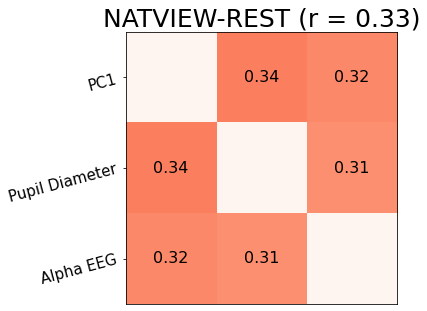

In [7]:
# chang, hcp, spreng, natview, nki_rest
dataset_mcca = 'natview'

# permutation parameters
permute=False
n_permute=100
permute_group = []

# spline basis parameters
nknots=3
lag_vec = np.arange(lag_n[dataset_mcca]+1)

basis_group = [[] for i in range(len(mcca_vars[dataset_mcca]))]
data_group = [[] for i in range(len(mcca_vars[dataset_mcca]))]
subject, scan = load_subject_list(dataset_mcca, params[dataset_mcca]['subject_list'])
for subj, sc in zip(subject, scan):
    # Load Subject
    df = load_subj(
        subj, sc, dataset_mcca, params[dataset_mcca],
        pca_dict[dataset_mcca][f'{subj}_{sc}'], pca_index=0
    )
    # flip sign for PC1, if necessary
    df['PC1'] = df['PC1'] * pca_sign_dict[d]
    # normalize data before concatenation
    df = df.apply(zscore, axis=0)
    # Create a separate dataframe for modeling w/ lag splines
    for i, p in enumerate(mcca_vars[dataset_mcca]):
        basis, lag_spline = lag_basis(df[p], lag_vec, nknots)
        # Trim NaNs introduced from lag splines
        na_indx = ~(np.isnan(basis).any(axis=1))
        basis_group[i].append(basis[na_indx, :])
        data_group[i].append(df[p].loc[na_indx])

basis_concat = [np.vstack(g) for g in basis_group]
data_concat = [np.hstack(g).T for g in data_group]

# Fit MCCA
mcca = MCCA(latent_dimensions=2, random_state=0)
mcca.fit(basis_concat)

# average pair-wise correlation
mcca_r = mcca.score(basis_concat)

# explained covariance
exp_covar = mcca.explained_covariance_ratio(basis_concat)

# compute permutation distribution, if specified
if permute:
    perm_r = []
    n_subj = len(basis_group[0])
    for n in range(n_permute):
        subj_shuffle = []
        for b in range(len(basis_group)):
            subj_list = np.arange(n_subj)
            np.random.shuffle(subj_list)
            subj_shuffle.append(subj_list)
        perm_basis = [[basis[s] for s in subj_vec] for basis, subj_vec in zip(basis_group, subj_shuffle)]
        perm_basis_concat = [np.vstack(g) for g in perm_basis]
        # Fit MCCA
        mcca_cv = MCCA(latent_dims=3, random_state=0)
        mcca_cv.fit(perm_basis_concat)
        # MCCA corr
        perm_r.append(mcca_cv.score(perm_basis_concat)[0])

    print(f'perm pval: {(sum(perm_r > mcca_r[0]) + 1) / (len(perm_r) + 1)}')
# Plot correlation matrix
corr_mat = mcca.pairwise_correlations(basis_concat)

new_labels = [physio_label_dict[p] for p in mcca_vars[dataset_mcca]]
corr_mat = pd.DataFrame(corr_mat[:,:,0], columns=new_labels, index=new_labels)
corr_mat_array = corr_mat.values
np.fill_diagonal(corr_mat_array, 0)

fig, ax = plt.subplots(figsize=(8,5))
im = ax.imshow(corr_mat_array, vmin=0, vmax=0.8, cmap='Reds')
ax.set_xticks([])
# ax.set_xticks(np.arange(len(new_labels)))
ax.set_yticks(np.arange(len(new_labels)))
# ax.set_xticklabels(new_labels, rotation=45, fontsize=15)
ax.set_yticklabels(new_labels, fontsize=15, rotation=15)

for (j,i),label in np.ndenumerate(corr_mat):
    if i != j:
        ax.text(i,j,round(label,2),ha='center',va='center', fontsize=16)
ax.set_title(f"{dataset_label_dict[dataset_mcca]} (r = {round(mcca_r[0],2)})", 
             fontsize=25)
# plt.colorbar(im, ax=ax)

# plt.savefig(f'mcca_corr_{dataset_mcca}', bbox_inches='tight')

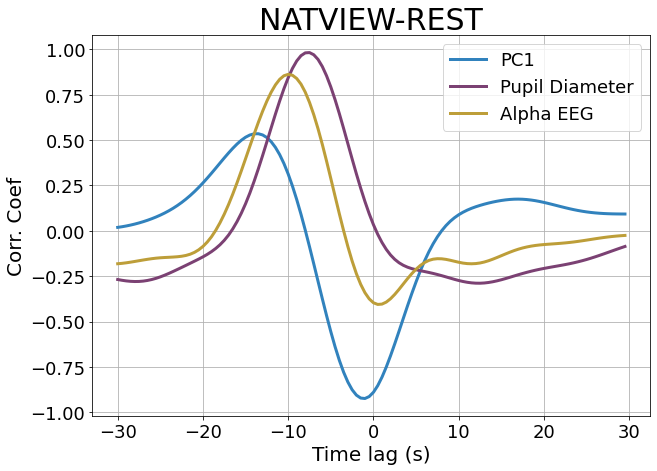

In [8]:
# Plot lags on first canonical component
cca_pred = mcca.transform(basis_concat)

# Inperpolation parameters
x_interp = np.arange(-30, 30, 0.5)
# specify length of cross-correlation function based on TR.
# we try to get around 30s 
cc_len = np.ceil(30/params[dataset_mcca]['tr']).astype(int)

cca_pred_df = pd.DataFrame(
    np.vstack([cca_pred[i][:,0] for i in range(len(new_labels))]).T,
    columns = mcca_vars[dataset_mcca]
)

fig, ax = plt.subplots(figsize=(10,7))

for i, c in enumerate(cca_pred_df.columns):
    cc_list = xcorr(data_concat[i]*cca_sign_dict[dataset_mcca][c], 
                     cca_pred[i][:,0], cc_len)
    f_interp = interp1d(cc_list[0]*(params[dataset_mcca]['tr']), cc_list[1], kind='cubic')
    cc_interp = f_interp(x_interp)
    # cc_interp = (cc_interp - cc_interp.min())/(cc_interp.max() - cc_interp.min()) # max/min norm
    ax.plot(x_interp, cc_interp, color=color_dict[c], 
            label=physio_label_dict[c], linewidth=3)
    ax.set_xlabel('Time lag (s)', fontsize=20)
    ax.set_title(dataset_label_dict[dataset_mcca], fontsize=30)
    # ax.set_ylabel('Rescaled Corr. Coef', fontsize=15)
    ax.set_ylabel('Corr. Coef', fontsize=20)

    ax.grid(True)

ax.tick_params(axis='both', which='major', labelsize=18)
ax.legend(fontsize=18)
# plt.savefig(f'mcca_pred_cc_{dataset_mcca}', bbox_inches='tight')

# 4. Impulse Response Functions

## 4.1 Gaussian Process Impulse Response Estimation

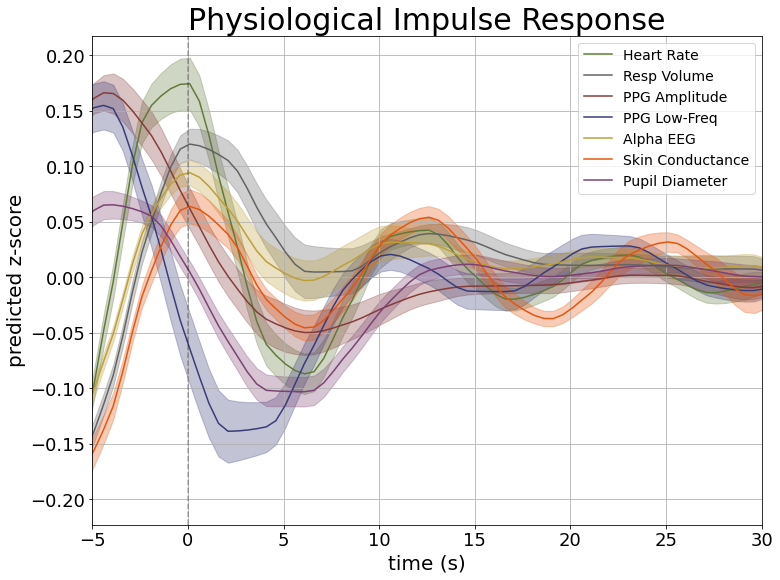

In [46]:
# utility function for loading datasets
def load_data(subject, scan, pca_dict, dataset, params):
    # loop through subject, scans and load physio and PC1 ts
    df_all = []
    for subj, sc in zip(subject, scan):
        # Load Subject
        df = load_subj(
            subj, sc, dataset, params,
            pca_dict[f'{subj}_{sc}'], pca_index=0
        )
        # flip sign for PC1, if necessary
        df['PC1'] = df['PC1'] * pca_sign_dict[dataset]
        # # normalize data before concatenation
        df = df.apply(zscore, axis=0)
        df_all.append(df)
    return df_all

# utility function for calculating cluster bootstrap standard errors
def bootstrap_se(df_list, physio, n_perms=100):
    # calculate bootstrapped standard errors
    n_subj = len(df_list)
    pred_perm = []
    for n in range(n_perms):
        perm_idx = np.random.choice(np.arange(n_subj), n_subj)
        df_full = pd.concat(
            [df_list[p] for p in perm_idx], axis=0, ignore_index=True
        )
        deconv_res = deconv_gp(
            df_full[p].values[:,np.newaxis], 
            df_full['PC1'].values[:, np.newaxis], 
            TR, tseg, ntaps, k, dt_rs
        )
        pred_perm.append(deconv_res['H_rs'])
    perm_se = list(np.std(pred_perm, axis=0).T)
    return perm_se

# GP deconvolution parameters
ntaps = 20
k=4 # shifts
TR = 2.1; # TR
dt_rs = 0.5

# initialize figure
fig, ax = plt.subplots(figsize=(12,9))

# load ME-REST physio data
subject, scan = load_subject_list('chang', params['chang']['subject_list'])
df = load_data(subject, scan, pca_dict['chang'], 'chang', params['chang'])
df_full = pd.concat(df, axis=0, ignore_index=True)
chang_physio = ['PPG_HR', 'RSP_RVT', 'PPG_PEAK_AMP', 'PPG_LOW', 'ALPHA']
tseg = np.arange(df_full.shape[0]);
for p in chang_physio:
    deconv_res = deconv_gp(
        df_full['PC1'].values[:, np.newaxis],
        df_full[p].values[:,np.newaxis], 
        TR, tseg, ntaps, k, dt_rs
    )
    ax.plot(deconv_res['tax_rs'], deconv_res['H_rs'],
            color=color_dict[p], 
            label=physio_label_dict[p])
    # get bootstrapped se
    physio_se = bootstrap_se(df, chang_physio)[0]
    ax.fill_between(
        deconv_res['tax_rs'], deconv_res['H_rs'][:,0]-physio_se, 
        deconv_res['H_rs'][:,0]+physio_se, alpha=0.3, 
        color=color_dict[p]
    )

# load NKI-REST physio data
subject, scan = load_subject_list('nki_rest', params['nki_rest']['subject_list'])
df = load_data(subject, scan, pca_dict['nki_rest'], 'nki_rest', 
               params['nki_rest'])
df_full = pd.concat(df, axis=0, ignore_index=True)
nki_physio = ['GSR']
tseg = np.arange(df_full.shape[0]);
for p in nki_physio:
    deconv_res = deconv_gp(
        df_full['PC1'].values[:, np.newaxis],
        df_full[p].values[:,np.newaxis], 
        TR, tseg, ntaps, k, dt_rs
    )
    ax.plot(deconv_res['tax_rs'], deconv_res['H_rs'],
            color=color_dict[p], 
            label=physio_label_dict[p])
    # get bootstrapped se
    physio_se = bootstrap_se(df, chang_physio)[0]
    ax.fill_between(
        deconv_res['tax_rs'], deconv_res['H_rs'][:,0]-physio_se, 
        deconv_res['H_rs'][:,0]+physio_se, alpha=0.3, 
        color=color_dict[p]
    )


# load NATVIEW physio data
subject, scan = load_subject_list('natview', params['natview']['subject_list'])
df = load_data(subject, scan, pca_dict['natview'], 
               'natview', params['natview'])
df_full = pd.concat(df, axis=0, ignore_index=True)
natview_physio = ['PUPIL']
tseg = np.arange(df_full.shape[0]);
for p in natview_physio:
    deconv_res = deconv_gp(
        df_full[p].values[:,np.newaxis], 
        df_full['PC1'].values[:, np.newaxis], 
        TR, tseg, ntaps, k, dt_rs
    )
    ax.plot(deconv_res['tax_rs'], deconv_res['H_rs'],
            color=color_dict[p], 
            label=physio_label_dict[p])
    # get bootstrapped se
    physio_se = bootstrap_se(df, chang_physio)[0]
    ax.fill_between(
        deconv_res['tax_rs'], deconv_res['H_rs'][:,0]-physio_se, 
        deconv_res['H_rs'][:,0]+physio_se, alpha=0.3, 
        color=color_dict[p]
    )

ax.grid(True)
ax.axvline(0, 0, 1, linestyle='--', color='black', alpha=0.3)
ax.set_xlabel('time (s)', fontsize=20)
ax.set_ylabel('predicted z-score', fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=18)
ax.set_xlim([-5, 30])
ax.legend(fontsize=14)
ax.set_title('Physiological Impulse Response', fontsize=30)

plt.savefig('physio_impf.png', bbox_inches='tight')

# 5. Cue - Deep Inhalation Task

## 5.1. Metadata

In [8]:
# Create task block indices
bh_events = load_chang_bh_event_file()
bh_event_blocks = construct_task_blocks('chang_bh', bh_events, 0)
bh_event_blocks = [tuple(b) for b in bh_event_blocks[0][1]]

# Load compliance data for chang_bh data (i.e. did they take a breath)
compliance = pd.read_csv('data/dataset_chang_bh/compliance.csv')
compliance = compliance.set_index(
    compliance['subject'].astype(str) + '_' + compliance['scan'].astype(str)
)
trial_cols = [f'trial{n+1}' for n in range(9)]

# Specify subject scans
subj_scan_dict = {
    '15': ['0009', '0015'],
    '17': ['0006', '0015'],
    '19': ['0016', '0022'],
    '20': ['0012'],
    '21': ['0009'],
    '25': ['0012']
}

## 5.2 Event-Related Physio Average

Text(0.5, 1.0, 'Cue With Deep Breath Trial Average')

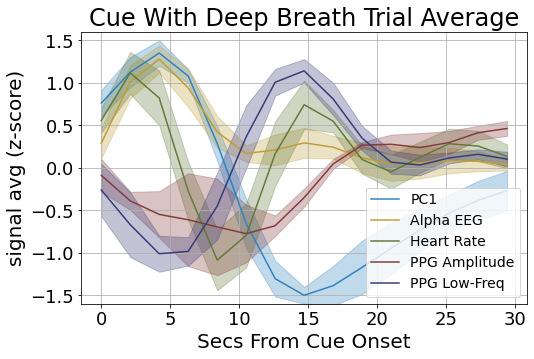

In [10]:
# physiological signal selection
physio_select = ['PC1', 'ALPHA', 'PPG_HR', 'PPG_PEAK_AMP', 'PPG_LOW']

physio_labels = [physio_label_dict[p] for p in physio_select]
physio_list = [[] for i in range(len(physio_select))]


# loop through subjects and their scans and event average
for subj in subj_scan_dict:
    physio_block_list = [[] for i in range(len(physio_select))]
    # Concatenate trials across scans from the same subject
    for scan in subj_scan_dict[subj]:
        df_subj = load_subj(subj, scan, 'chang_bh', params['chang_bh'], 
                            pca_dict['chang_bh'][f'{subj}_{scan}'], 
                            pca_index=0)
        # flip sign for PC1, if necessary
        df_subj['PC1'] = df_subj['PC1'] * pca_sign_dict['chang_bh']
        # normalize z-score for averaging
        df_subj = df_subj.apply(zscore, axis=0)
        # Load compliance for scan
        scan_compliance = compliance.loc[f'{subj}_{int(scan)}'][trial_cols].values
        # Filter out non-compliant trials
        task_blocks = [block for block, c in zip(bh_event_blocks, scan_compliance) if c == 1]
        for i, p in enumerate(physio_select):
            p_ts = df_subj[p].values[np.newaxis, :]
            physio_block_list[i].append(np.squeeze(p_ts[:, task_blocks]))
    # Concatenate trials across scans
    physio_block_list = [np.vstack(p_blocks) for p_blocks in physio_block_list]
    for i, p in enumerate(physio_select):
        physio_list[i].append(physio_block_list[i])

# Concatenate trials across all subjects
physio_trials = [np.vstack(p) for p in physio_list]
physio_avg = [np.mean(p_trials, axis=0) for p_trials in physio_trials]
n_trials = len(physio_trials[0])

# Bootstrap standard errors
physio_array = np.array(physio_list, dtype='object') # makes indexing easier
n_subj = len(physio_list[0])
n_perms = 100
perms_avg = []
for i in range(n_perms):
    perm_sample = np.random.choice(np.arange(n_subj), n_subj)
    physio_trials_perm = [np.vstack(p[perm_sample]) for p in physio_array]
    perms_avg.append([np.mean(p_trials, axis=0) for p_trials in physio_trials_perm])
perms_avg_array = np.stack(perms_avg, axis=2)  
physio_se = np.std(perms_avg_array, axis=2)

fig, ax = plt.subplots(figsize=(8,5))
trial_len = len(physio_avg[0])
trial_sec = np.arange(trial_len)/(1/params['chang_bh']['tr'])
for p_avg, p_se, p, p_label in zip(physio_avg, physio_se, physio_select, physio_labels):
    ax.plot(trial_sec, p_avg, label=p_label, color=color_dict[p])
    ax.fill_between(trial_sec, p_avg-p_se, p_avg+p_se, alpha=0.3, color=color_dict[p])

ax.legend(fontsize=14)
ax.grid(True)
ax.set_xlabel('Secs From Cue Onset', fontsize=20)
ax.set_ylabel('signal avg (z-score)', fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=18)
ax.set_ylim(-1.6,1.6)
t_label = 'Cue With Deep Breath Trial Average'
ax.set_title(t_label, fontsize=24)
# plt.savefig(f'{dataset_avg}_avg.png', bbox_inches='tight')

## 5.3 Event-Related EEG Evoked Power Average

Using data from preloaded Raw for 7 events and 3001 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 9 events and 3001 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 9 events and 3001 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 9 events and 3001 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 7 events and 3001 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 8 events and 3001 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 9 events and 3001 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 9 events and 3001 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 9 events and 3001 original time points ...
0 bad epochs dropped


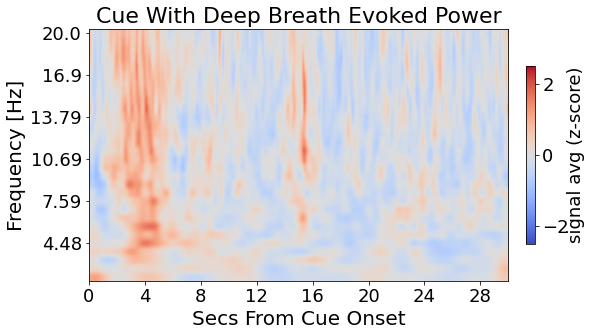

In [25]:
# Load event timing
events = bh_events.copy()
# Account for 7 TRs removed from functional
events = events - 14.7 

# Specify upper and lower limits of frequency range
freqs = np.linspace(2,20,30)

# length of window after cue to average
event_dur = 30 # 30 seconds

# Loop through subjects and calculate evoked power
power_group = []
for subj in subj_scan_dict:
    # Concatenate trials across scans from the same subject
    for scan in subj_scan_dict[subj]:
        raw = mne.io.read_raw_fif(params['chang_bh']['eeg'].format(subj, scan), 
                                  preload=True, verbose=False)
        # Only average trials where the subject took a breath
        subj_compliance = compliance.loc[f'{subj}_{int(scan)}'][trial_cols]
        annot = ['BREATH' if i == 1 else 'bad BREATH' for i in subj_compliance]
        event_annot = mne.Annotations(onset=events, duration=event_dur, description=annot)
        raw.set_annotations(event_annot)
        events_mne, event_annot = mne.events_from_annotations(raw, verbose=False)
        epochs = mne.Epochs(raw, events_mne, 1, 0, event_dur, reject_by_annotation = True, 
                            baseline = None, verbose=False)
        n_cycles = 15 # number of cycles parameter for wavelet
        # Morlet wavelet evoked power average
        power_avg = tfr_morlet(epochs, freqs=freqs, n_cycles=n_cycles, return_itc=False, average=True)
        ch_names = power_avg.ch_names
        # z-score power time courses
        power_avg.apply_baseline(baseline=(None, None), mode='zscore', verbose=False)
        # Convert to Pandas dataframe for further processing
        power_df = power_avg.to_data_frame(index=None)
        power_df['avg_chan'] = power_df[ch_names].mean(axis=1)
        power_df['freq_indx'] = power_df.groupby('freq').transform('cumcount')
        power_df['subj'] = f'{subj}_{scan}'
        power_group.append(power_df[['subj', 'time','freq','freq_indx', 'avg_chan']])

# Concatenate subject evoked power averages across subjects
power_group = pd.concat(power_group, axis=0)

# Across-subject evoked power average
power_group_avg = power_group.groupby(['freq', 'freq_indx'])['avg_chan'].mean()
power_group_avg = power_group_avg.unstack().values

# Plot 
fig, ax = plt.subplots(figsize=(8,10))
im = ax.imshow(power_group_avg[::-1, :], aspect=60,  cmap='coolwarm', 
               vmin=-2.5, vmax=2.5)
times = power_avg.times
t_sample = np.arange(0, len(times), 400)
ax.set_xticks(t_sample)
ax.set_xticklabels(times[t_sample].astype('int'))
ax.set_xlabel('Secs From Cue Onset', fontsize=20)

freq_sample = np.arange(0,len(freqs),5)
ax.set_yticks(freq_sample)
ax.set_yticklabels(np.round(freqs[::-1][freq_sample],2))
ax.set_ylabel('Frequency [Hz]', fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=18)
cbar = plt.colorbar(im,fraction=0.02, pad=0.04)
cbar.ax.tick_params(labelsize=18)
cbar.set_label('signal avg (z-score)', fontsize=18, labelpad=-2)

t_label = 'Cue With Deep Breath Evoked Power'
ax.set_title(t_label, fontsize=22)
plt.savefig(f'chang_bh_power_avg.png', bbox_inches='tight')

# 6. Cue - Button Response Task

## 6.1 Event-Related Physio Average

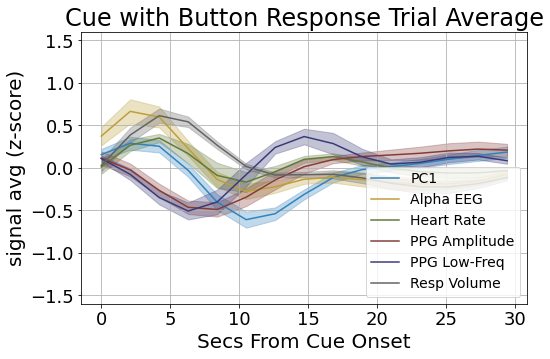

In [5]:
# whether to filter by PPG amplitude
ppg_filt=False
ppg_cutoff=-1 # in z-score units
cutoff_win = 10

# physiological signal selection
physio_select = ['PC1', 'ALPHA', 'PPG_HR', 'PPG_PEAK_AMP', 'PPG_LOW', 'RSP_RVT']
physio_labels = [physio_label_dict[p] for p in physio_select]
physio_list = [[] for i in range(len(physio_select))]

# get subject list
subject, scan = load_subject_list(
    'chang_cue', params['chang_cue']['subject_list']
)

# function to detect overlapping trials
def detect_overlap(indx, intervals):
    intervals_c = intervals.copy()
    k_range = set(intervals[indx])
    del intervals_c[indx]
    if any([len(k_range.intersection(k))>2 for k in intervals_c]):
        return True
    else:
        return False

# loop through subjects and concatenate trials
block_list = []
for subj, sc in zip(subject, scan):
    # Load subject data
    df = load_subj(subj, sc, 'chang_cue', params['chang_cue'], 
                   pca_dict['chang_cue'][f'{subj}_{sc}'], 
                   pca_index=0)
    # flip sign for PC1, if necessary
    df['PC1'] = df['PC1'] * pca_sign_dict['chang_cue']
    # normalize z-score for averaging
    df = df.apply(zscore, axis=0)
    # load event onsets
    cue_events, cue_rt = load_chang_cue_event_file(subj, sc)
    cue_event_blocks = construct_task_blocks('chang_cue', cue_events, 0)
    cue_event_blocks = [tuple(b) for b in cue_event_blocks[0][1]]
    # filter out blocks that extend beyond length of scan
    # load number of volumes in functional scan
    func_len = nb.load(params['chang_cue']['func'].format(subj, sc)).shape[-1]
    # filter out trials occuring before (trimmed) func start, after end of func,
    # and with no response
    cue_events_filt = [b for b, rt in zip(cue_event_blocks, cue_rt)
                       if (b[-1] < func_len) and (b[0] >= 0) 
                       and ~np.isnan(rt)]
    # filter overlapping windows
    block_list.append(cue_events_filt)
    cue_events_filt = [e for i, e in enumerate(cue_events_filt) 
                        if not detect_overlap(i, cue_events_filt)]
    # loop through physio signals and add to list
    physio_block_list = [[] for i in range(len(physio_select))]
    for i, p in enumerate(physio_select):
        p_ts = df[p].values[np.newaxis, :]
        physio_block_list[i].append(np.squeeze(p_ts[:, cue_events_filt]))
        
    # Concatenate trials across scans, if multiple
    physio_block_list = [np.vstack(p_blocks) for p_blocks in physio_block_list]
    for i, p in enumerate(physio_select):
        physio_list[i].append(physio_block_list[i])

# filter trials by PPG amplitude
if ppg_filt:
    ppg_i = physio_select.index('PPG_PEAK_AMP')
    window = np.ceil(cutoff_win/params['chang_cue']['tr']).astype(int)
    trial_mask = [[True if np.any(t[:window] < ppg_cutoff) else False for t in s] 
                  for s in physio_list[ppg_i]]
    physio_list_filt = []
    for physio_trials in physio_list:
        physio_trials_filt = [[p for mask, p in zip(s_m, s_p) if mask] 
                             for s_m, s_p in zip(trial_mask, physio_trials)]
        physio_trials_filt = [[p for p in s_p] for s_p in physio_trials_filt 
                              if len(s_p) > 0]
        physio_list_filt.append(physio_trials_filt)
    physio_list = physio_list_filt

# Concatenate trials across all subjects
physio_trials = [np.vstack(p) for p in physio_list]
physio_avg = [np.mean(p_trials, axis=0) for p_trials in physio_trials]
n_trials = len(physio_trials[0])

# Bootstrap standard errors
physio_array = np.array(physio_list, dtype='object') # makes indexing easier
n_subj = len(physio_list[0])
n_perms = 100
perms_avg = []
for i in range(n_perms):
    perm_sample = np.random.choice(np.arange(n_subj), n_subj)
    physio_trials_perm = [np.vstack(p[perm_sample]) for p in physio_array]
    perms_avg.append([np.mean(p_trials, axis=0) for p_trials in physio_trials_perm])
perms_avg_array = np.stack(perms_avg, axis=2)  
physio_se = np.std(perms_avg_array, axis=2)

# plot trial averages
fig, ax = plt.subplots(figsize=(8,5))
trial_len = len(physio_avg[0])
trial_sec = np.arange(trial_len)/(1/params['chang_cue']['tr'])
for p_avg, p_se, p, p_label in zip(physio_avg, physio_se, physio_select, physio_labels):
    ax.plot(trial_sec, p_avg, label=p_label, color=color_dict[p])
    ax.fill_between(trial_sec, p_avg-p_se, p_avg+p_se, alpha=0.3, color=color_dict[p])

ax.legend(fontsize=14, loc='lower right')
ax.grid(True)
ax.set_title('Cue with Button Response Trial Average', fontsize=24)
ax.set_xlabel('Secs From Cue Onset', fontsize=20)
ax.set_ylabel('signal avg (z-score)', fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=18)
ax.set_ylim(-1.6,1.6)
plt.savefig('chang_cue_avg.png', bbox_inches='tight')

## 6.2 Event-Related EEG Evoked Power Average

Using data from preloaded Raw for 25 events and 3001 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 13 events and 3001 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 25 events and 3001 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 19 events and 3001 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 32 events and 3001 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 20 events and 3001 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 20 events and 3001 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 18 events and 3001 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 8 events and 3001 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 18 events and 3001 original time points ...
0 bad epochs dropped
Using data 

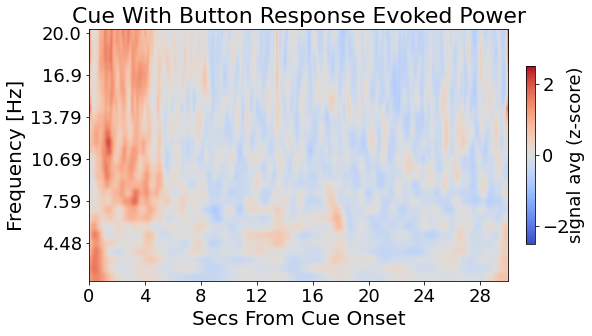

In [24]:
# Specify upper and lower limits of frequency range
freqs = np.linspace(2,20,30)

# length of window after cue to average
event_dur = 30 # 30 seconds

# get subject list
subject, scan = load_subject_list(
    'chang_cue', params['chang_cue']['subject_list']
)

# Loop through subjects and calculate evoked power
power_group = []
for subj, sc in zip(subject, scan):
    raw = mne.io.read_raw_fif(params['chang_cue']['eeg'].format(subj, sc), 
                              preload=True, verbose=False)
    # load event onsets
    cue_events, cue_rt = load_chang_cue_event_file(subj, sc)
    # convert event ms to s, and subtract 14.7s sec to align with EEG
    cue_events_s = (cue_events/1000) - 14.7
    cue_event_blocks = construct_task_blocks('chang_cue', cue_events, 0)
    cue_event_blocks = [tuple(b) for b in cue_event_blocks[0][1]]
    # filter out blocks that extend beyond length of scan
    # load number of volumes in functional scan
    func_len = nb.load(params['chang_cue']['func'].format(subj, sc)).shape[-1]
    # filter out trials occuring before (trimmed) func start, after end of func,
    # and with no response
    event_block_filt = [
        (e,b) for e, b, rt in zip(cue_events_s, cue_event_blocks, cue_rt)
        if (b[-1] < func_len) and (b[0] >= 0) and ~np.isnan(rt)
    ]
    events_filt, blocks_filt = map(list, zip(*event_block_filt))
    # filter overlapping windows
    cue_events_s_filt = [
        e for i, (e, b) in enumerate(zip(events_filt, blocks_filt)) 
        if not detect_overlap(i, blocks_filt)
    ]
    # Annotate raw MNE obj
    event_annot = mne.Annotations(onset=cue_events_s_filt, duration=event_dur, description='CUE')
    raw.set_annotations(event_annot)
    events_mne, event_annot = mne.events_from_annotations(raw, verbose=False)
    epochs = mne.Epochs(raw, events_mne, 1, 0, event_dur, reject_by_annotation = True, 
                        baseline = None, verbose=False)
    n_cycles = 15 # number of cycles parameter for wavelet
    # Morlet wavelet evoked power average
    power_avg = tfr_morlet(epochs, freqs=freqs, n_cycles=n_cycles, return_itc=False, average=True)
    ch_names = power_avg.ch_names
    # z-score power time courses
    power_avg.apply_baseline(baseline=(None, None), mode='zscore', verbose=False)
    # Convert to Pandas dataframe for further processing
    power_df = power_avg.to_data_frame(index=None)
    power_df['avg_chan'] = power_df[ch_names].mean(axis=1)
    power_df['freq_indx'] = power_df.groupby('freq').transform('cumcount')
    power_df['subj'] = f'{subj}_{scan}'
    power_group.append(power_df[['subj', 'time','freq','freq_indx', 'avg_chan']])

# Concatenate subject evoked power averages across subjects
power_group = pd.concat(power_group, axis=0)

# Across-subject evoked power average
power_group_avg = power_group.groupby(['freq', 'freq_indx'])['avg_chan'].mean()
power_group_avg = power_group_avg.unstack().values

# Plot 
fig, ax = plt.subplots(figsize=(8,10))
im = ax.imshow(power_group_avg[::-1, :], aspect=60,  cmap='coolwarm', 
               vmin=-2.5, vmax=2.5)
times = power_avg.times
t_sample = np.arange(0, len(times), 400)
ax.set_xticks(t_sample)
ax.set_xticklabels(times[t_sample].astype('int'))
ax.set_xlabel('Secs From Cue Onset', fontsize=20)

freq_sample = np.arange(0,len(freqs),5)
ax.set_yticks(freq_sample)
ax.set_yticklabels(np.round(freqs[::-1][freq_sample],2))
ax.set_ylabel('Frequency [Hz]', fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=18)
cbar = plt.colorbar(im,fraction=0.02, pad=0.04)
cbar.ax.tick_params(labelsize=18)
cbar.set_label('signal avg (z-score)', fontsize=18, labelpad=-2)

t_label = 'Cue With Button Response Evoked Power'
ax.set_title(t_label, fontsize=22)
plt.savefig(f'chang_cue_power_avg.png', bbox_inches='tight')

# 7. K-Complex Event-Related Physio Average

## 7.1 Event-Related Physio Average

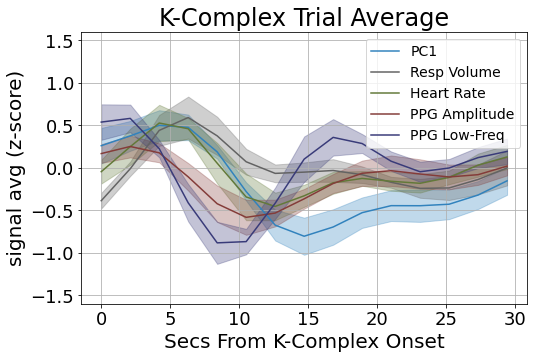

In [11]:
# chang dataset tr
tr = params['chang']['tr']
# length of window for event related avg
k_len = 15 # in tr units (15*2.1s)

# physiological signal selection
physio_select = ['PC1', 'RSP_RVT','PPG_HR', 'PPG_PEAK_AMP', 'PPG_LOW']
physio_labels = [physio_label_dict[p] for p in physio_select]
physio_list = [[] for i in range(len(physio_select))]


# funcion to detect overlap in k complex events
def detect_overlap(indx, intervals):
    intervals_c = intervals.copy()
    k_range = set(intervals[indx])
    del intervals_c[indx]
    if any([len(k_range.intersection(k))>0 for k in intervals_c]):
        return True
    else:
        return False

# load k-complex annotations
k_onsets = json.load(open('data/dataset_chang/k_complex_onsets.json', 'r'))

# loop through subject annotations and average
for k_annot in k_onsets:
    subj = k_annot['subject']
    scan = k_annot['scan']
    onsets = k_annot['k_onsets']
    # Trim off first 14.7s to align w/ functional (first 7 TRs were trimmed from functional)
    onsets = [o - 14.7 for o in onsets]
    # load number of volumes in functional scan
    func_len = nb.load(params['chang']['func'].format(subj, scan)).shape[-1]
    # vector of time points at functional sampling rate
    func_t = np.arange(1,func_len+1)*tr
    onsets_i = []
    onsets_func = []
    # assign k-complex onsets (in secs) to nearest TR
    for o in onsets:
        k_i = np.argmin(np.abs(func_t - o))
        onsets_i.append(k_i)
        onsets_func.append(func_t[k_i])
    # create windows around k-complex onset for averaging
    onsets_func_r = [range(k_i, k_i+k_len) for k_i in onsets_i if (k_i+k_len) <= func_len]
    # filter overlapping windows
    onsets_func_filt = [k for i, k in enumerate(onsets_func_r) 
                        if not detect_overlap(i, onsets_func_r)]
    physio_block_list = [[] for i in range(len(physio_select))]
    # load subject physio data
    df_subj = load_subj(subj, scan, 'chang', params['chang'], 
                        pca_dict['chang'][f'{subj}_{scan}'], 
                        pca_index=0)
    # flip sign for PC1, if necessary
    df_subj['PC1'] = df_subj['PC1'] * pca_sign_dict['chang']
    # normalize z-score for averaging
    df_subj = df_subj.apply(zscore, axis=0)
    for i, p in enumerate(physio_select):
        p_ts = df_subj[p].values[np.newaxis, :]
        physio_block_list[i].append(np.squeeze(p_ts[:, onsets_func_filt]))

    # Concatenate trials across scans, if multiple
    physio_block_list = [np.vstack(p_blocks) for p_blocks in physio_block_list]
    for i, p in enumerate(physio_select):
        physio_list[i].append(physio_block_list[i])
        
# Concatenate trials across all subjects
physio_trials = [np.vstack(p) for p in physio_list]
physio_avg = [np.mean(p_trials, axis=0) for p_trials in physio_trials]
n_trials = len(physio_trials[0])
        

# Bootstrap standard errors
physio_array = np.array(physio_list, dtype='object') # makes indexing easier
n_subj = len(physio_list[0])
n_perms = 100
perms_avg = []
for i in range(n_perms):
    perm_sample = np.random.choice(np.arange(n_subj), n_subj)
    physio_trials_perm = [np.vstack(p[perm_sample]) for p in physio_array]
    perms_avg.append([np.mean(p_trials, axis=0) for p_trials in physio_trials_perm])
perms_avg_array = np.stack(perms_avg, axis=2)  
physio_se = np.std(perms_avg_array, axis=2)

fig, ax = plt.subplots(figsize=(8,5))
trial_len = len(physio_avg[0])
trial_sec = np.arange(trial_len)/(1/params['chang']['tr'])
for p_avg, p_se, p, p_label in zip(physio_avg, physio_se, physio_select, physio_labels):
    ax.plot(trial_sec, p_avg, label=p_label, color=color_dict[p])
    ax.fill_between(trial_sec, p_avg-p_se, p_avg+p_se, alpha=0.3, color=color_dict[p])

ax.legend(fontsize=14)
ax.grid(True)
ax.set_xlabel('Secs From K-Complex Onset', fontsize=20)
ax.set_ylabel('signal avg (z-score)', fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=18)
ax.set_ylim(-1.6,1.6)
ax.set_title('K-Complex Trial Average', fontsize=24)
        
plt.savefig(f'k_complex_avg.png', bbox_inches='tight')

## 7.2 Event-Related EEG Evoked Power Average

Using data from preloaded Raw for 7 events and 3001 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 7 events and 3001 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 2 events and 3001 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 8 events and 3001 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 5 events and 3001 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 5 events and 3001 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 3 events and 3001 original time points ...
0 bad epochs dropped


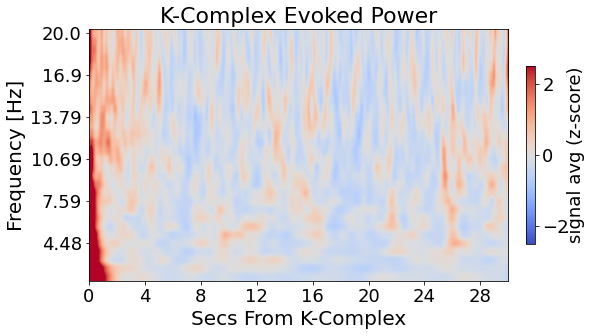

In [12]:
# Specify upper and lower limits of frequency range
freqs = np.linspace(2,20,30)

# length of window after K-Complex to average
event_dur = 30 # 30 seconds

# Loop through subjects and calculate evoked power
power_group = []
# loop through subject annotations and average
for k_annot in k_onsets:
    subj = k_annot['subject']
    scan = k_annot['scan']
    raw = mne.io.read_raw_fif(params['chang']['eeg'].format(subj, scan), 
                              preload=True, verbose=False)
    onsets = k_annot['k_onsets']
    # Trim off first 14.7s to align w/ functional (first 7 TRs were trimmed from functional)
    onsets = [o - 14.7 for o in onsets]
    # load number of volumes in functional scan
    func_len = nb.load(params['chang']['func'].format(subj, scan)).shape[-1]
    # vector of time points at functional sampling rate
    func_t = np.arange(1,func_len+1)*tr
    onsets_i = []
    onsets_func = []
    # assign k-complex onsets (in secs) to nearest TR
    for o in onsets:
        k_i = np.argmin(np.abs(func_t - o))
        onsets_i.append(k_i)
        onsets_func.append(func_t[k_i])
    # create windows around k-complex onset for averaging
    onsets_func_r = [range(k_i, k_i+k_len) for k_i in onsets_i if (k_i+k_len) <= func_len]
    # filter overlapping windows
    onsets_filt = [o for i, (o, b) in enumerate(zip(onsets, onsets_func_r))
                   if not detect_overlap(i, onsets_func_r)]
    # annotate raw MNE obj
    event_annot = mne.Annotations(onset=onsets_filt, duration=event_dur, description='KCOMPLEX')
    raw.set_annotations(event_annot)
    events_mne, event_annot = mne.events_from_annotations(raw, verbose=False)
    epochs = mne.Epochs(raw, events_mne, 1, 0, event_dur, reject_by_annotation = True, 
                        baseline = None, verbose=False)
    n_cycles = 15 # number of cycles parameter for wavelet
    # Morlet wavelet evoked power average
    power_avg = tfr_morlet(epochs, freqs=freqs, n_cycles=n_cycles, return_itc=False, average=True)
    ch_names = power_avg.ch_names
    # z-score power time courses
    power_avg.apply_baseline(baseline=(None, None), mode='zscore', verbose=False)
    # Convert to Pandas dataframe for further processing
    power_df = power_avg.to_data_frame(index=None)
    power_df['avg_chan'] = power_df[ch_names].mean(axis=1)
    power_df['freq_indx'] = power_df.groupby('freq').transform('cumcount')
    power_df['subj'] = f'{subj}_{scan}'
    power_group.append(power_df[['subj', 'time','freq','freq_indx', 'avg_chan']])

# Concatenate subject evoked power averages across subjects
power_group = pd.concat(power_group, axis=0)

# Across-subject evoked power average
power_group_avg = power_group.groupby(['freq', 'freq_indx'])['avg_chan'].mean()
power_group_avg = power_group_avg.unstack().values

# Plot 
fig, ax = plt.subplots(figsize=(8,10))
im = ax.imshow(power_group_avg[::-1, :], aspect=60,  cmap='coolwarm', 
               vmin=-2.5, vmax=2.5)
times = power_avg.times
t_sample = np.arange(0, len(times), 400)
ax.set_xticks(t_sample)
ax.set_xticklabels(times[t_sample].astype('int'))
ax.set_xlabel('Secs From K-Complex', fontsize=20)

freq_sample = np.arange(0,len(freqs),5)
ax.set_yticks(freq_sample)
ax.set_yticklabels(np.round(freqs[::-1][freq_sample],2))
ax.set_ylabel('Frequency [Hz]', fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=18)
cbar = plt.colorbar(im,fraction=0.02, pad=0.04)
cbar.ax.tick_params(labelsize=18)
cbar.set_label('signal avg (z-score)', fontsize=18, labelpad=-2)

t_label = 'K-Complex Evoked Power'
ax.set_title(t_label, fontsize=22)
plt.savefig(f'k_complex_power_avg.png', bbox_inches='tight')

# 7. Clamped CO2 vs. Free Breathing

## 7.1 PC1 Spatial Weights

sizeof_hdr should be 348; set sizeof_hdr to 348


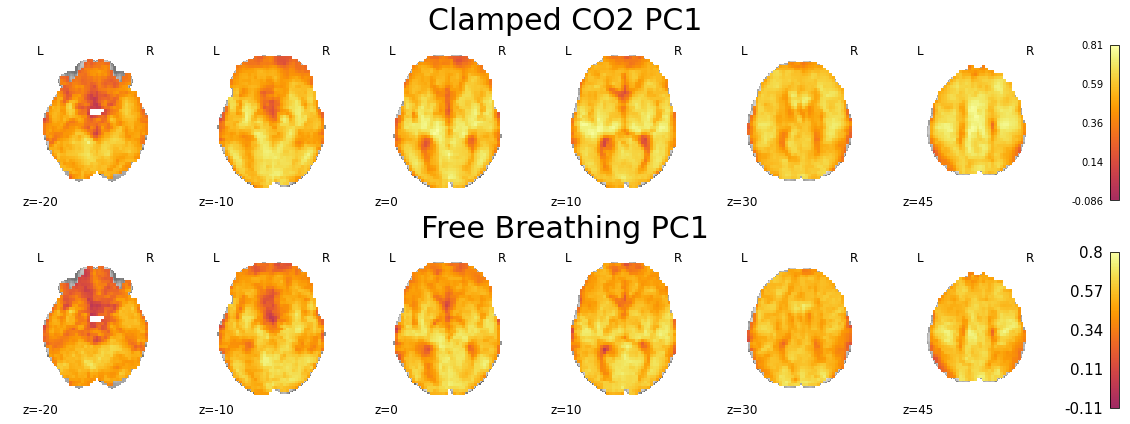

In [13]:
# load principal component weights
nii_free_fp = 'results/pca/toronto_free_pca.nii'
nii_clamped_fp = 'results/pca/toronto_clamped_pca.nii'
# load niftis w/ nibabel
nii_free = nb.load(nii_free_fp)
nii_clamped = nb.load(nii_clamped_fp)
# index nifti to select first principal component weights
pc1_free = index_img(nii_free, 0)
pc1_clamped = index_img(nii_clamped, 0)

# flip signs for consistency (flip free breathing to match clamped)
data = pc1_free.get_fdata()
data[:] *= -1
pc1_free = nb.Nifti1Image(data, affine=nii_free.affine,
                          header=nii_free.header)
# plot first principal component weights for both conditions
fig, axs = plt.subplots(2,1, figsize=(20,7))

# manually define cuts of z-axis (axial slices)
z = [-20, -10, 0, 10, 30, 45]

plotting.plot_stat_map(
    pc1_free,
    display_mode="z",
    cut_coords=z,
    cmap='inferno',
    vmax=0.8,
    symmetric_cbar=False,
    axes=axs[0],
    
)

plotting.plot_stat_map(
    pc1_clamped,
    display_mode="z",
    cut_coords=z,
    cmap='inferno',
    vmax=0.8,
    symmetric_cbar=False,
    axes=axs[1],
)

axs[0].set_title('Clamped CO2 PC1', fontsize=30)
axs[1].set_title('Free Breathing PC1', fontsize=30)
# increase cbar font size
cbar = fig.axes[9]
cbar.tick_params(labelsize=15)
cbar = fig.axes[-1]
cbar.tick_params(labelsize=15)
plt.savefig('pc_weights_combined.png', bbox_inches='tight')

## 7.2 Explained Variance

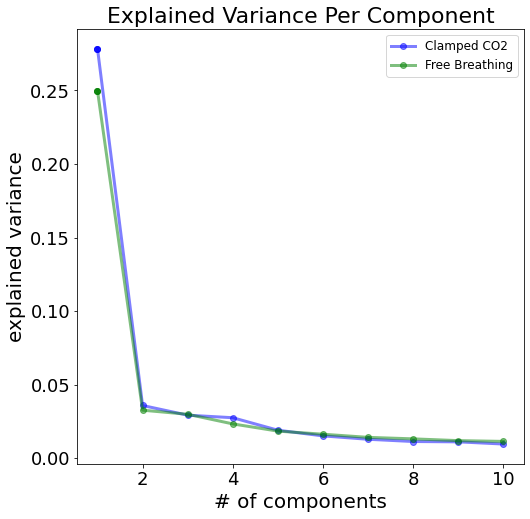

In [18]:
pca_free = pickle.load(open('results/pca/toronto_free_pca_results.pkl', 'rb'))
pca_clamped = pickle.load(open('results/pca/toronto_clamped_pca_results.pkl', 'rb'))

exp_var_free = pca_free['exp_var']
exp_var_clamped = pca_clamped['exp_var']

fig, ax = plt.subplots(figsize=(8,8))

ax.plot([1], exp_var_free[0], '-o', linewidth=3, color='blue', alpha=0.8)
ax.plot([1], exp_var_clamped[0], '-o', linewidth=3, color='green', alpha=0.8)

ax.plot(np.arange(1, 11), exp_var_free[:11], '-o', 
        linewidth=3, color='blue', alpha=0.5, 
        label='Clamped CO2')
ax.plot(np.arange(1, 11), exp_var_clamped[:11], '-o', 
        linewidth=3, color='green', alpha=0.5, 
        label='Free Breathing')

ax.set_xlabel('# of components', fontsize=20)
ax.set_ylabel('explained variance', fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=18)
ax.set_title('Explained Variance Per Component', fontsize=22)
ax.legend(fontsize=12)
# plt.savefig('expvar.png')

In [8]:
np.corrcoef(pca_free['loadings'][0,:], pca_clamped['loadings'][0,:])

array([[ 1.        , -0.95338937],
       [-0.95338937,  1.        ]])

# 8. Supplementary

## 8.1 First Complex Principal Component

### 8.1.1 CPCA Dataset Metadata

In [ ]:
# phase shift to align CPC1 reconstructed time course to Chang CPC1 reconstructed time course
t_shift = {
    'chang': {
        't_shift': 0,
        'p_shift': 0
    },
    'hcp': {
        't_shift': 9,
        'p_shift': 1.99
    },
    'natview': {
        't_shift': 16,
        'p_shift': 3.46
    },
    'nki_rest': {
        't_shift': 0,
        'p_shift': 0
    },
    'spreng': {
        't_shift': 3,
        'p_shift': 0.73
    }
}

# time point selections for display
phase_samples = [0,5,10,15,20,25]

### 8.1.2 Reconstructed CPC1 Time Course

sizeof_hdr should be 348; set sizeof_hdr to 348


Text(0.5, 0.92, 'ME-REST-SUPP CPC1 Time Points')

findfont: Font family ['cmsy10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmr10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmtt10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmmi10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmb10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmss10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmex10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['DejaVu Sans Mono'] not found. Falling back to DejaVu Sans.
findfont: Font family ['DejaVu Sans Display'] not found. Falling back to DejaVu Sans.


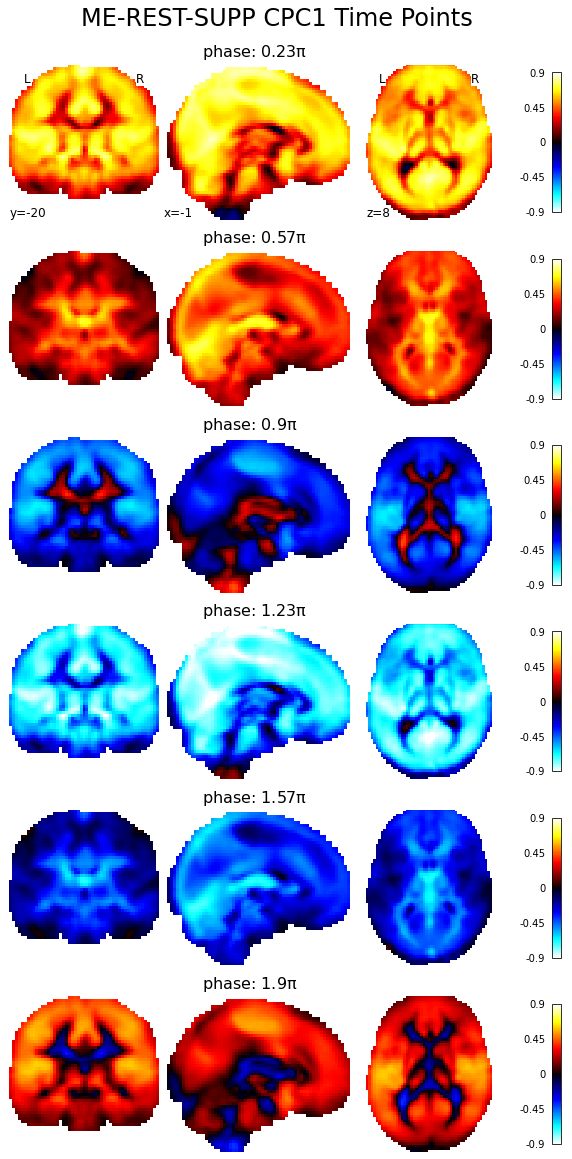

In [30]:
# choose dataset
dataset_cpca = 'spreng'

# plot selected time points
fig, axs = plt.subplots(6,1,figsize=(10,20))

# load in MNI mask and binarize
mask_bin = nb.load(params[dataset_cpca]['mask']).get_fdata() > 0

# load CPC1 reconstruction
cpca_recon_nii = nb.load(f'{pca_dir}/{dataset_cpca}_cpca_recon_n0.nii')
cpca_recon = pickle.load(open(f'{pca_dir}/{dataset_cpca}_cpca_recon_results.pkl', 'rb'))

# circular shift reconstructed time course to align with Chang CPC1
# convert reconstructed time course to 2d matrix
cpca_recon_data = convert_2d(mask_bin, cpca_recon_nii.get_fdata())
# shift phase 'time' points to match Chang CPC1
cpca_recon_shift = np.roll(cpca_recon_data, t_shift[dataset_cpca]['t_shift'], axis=0)
# convert 2d back to 4d nifti
cpca_recon_shift_4d = convert_4d(mask_bin, cpca_recon_shift)
cpca_recon_shift_nii = nb.Nifti1Image(cpca_recon_shift_4d, cpca_recon_nii.affine, 
                                       cpca_recon_nii.header)
for i, p in enumerate(phase_samples):
    bin_centers = cpca_recon[1][0]
    phase_val = bin_centers[np.mod(p+t_shift[dataset_cpca]['t_shift'], len(bin_centers))]

    p_label = f"phase: {round(phase_val/np.pi,2)}$\pi$"
    if i == 0:
        annotate=True
    else:
        annotate=False
    plotting.plot_stat_map(index_img(cpca_recon_shift_nii, p), bg_img=None, 
                           display_mode='ortho', figure=fig,
                           cut_coords=[-1, -20, 8], axes=axs[i],
                           draw_cross=False, annotate=annotate, vmax=0.9)
    axs[i].text(0.35, 1.05, p_label, fontsize=16) 

fig.suptitle(f'{dataset_label_dict[dataset_cpca]} CPC1 Time Points', fontsize=24, y=0.92)


## 8.2 PCA Explaned Variance Across Datasets 

### 8.2.1 Standard PCA

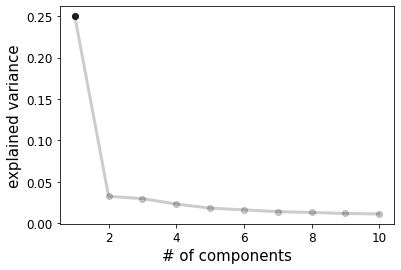

In [100]:
dataset = 'toronto_clamped'

pca_fp = f'results/pca/{dataset}_pca_results.pkl'

pca_res = pickle.load(open(pca_fp, 'rb'))
e = pca_res['exp_var']

fig, ax = plt.subplots()


ax.plot([1], e[0], '-o', linewidth=3, color='black', alpha=0.8)
ax.plot(np.arange(1, 11), e[:11], '-o', linewidth=3, color='black', alpha=0.2)
ax.set_xlabel('# of components', fontsize=15)
ax.set_ylabel('explained variance', fontsize=15)
ax.tick_params(axis='both', which='major', labelsize=12)



### 8.2.2 Complex PCA

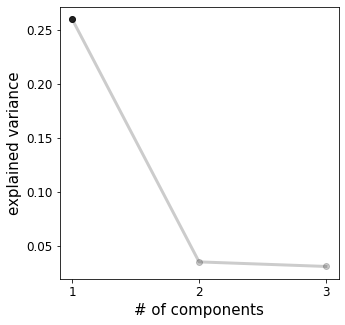

In [102]:
dataset = 'toronto_clamped'

cpca_fp = f'results/pca/{dataset}_pca_c_results.pkl'

cpca_res = pickle.load(open(cpca_fp, 'rb'))
e = cpca_res['exp_var']/2

fig, ax = plt.subplots(figsize=(5,5))

ax.plot([1], e[0], '-o', linewidth=3, color='black', alpha=0.8)
ax.plot(np.arange(1, 4), e[:3], '-o', linewidth=3, color='black', alpha=0.2)
ax.set_xlabel('# of components', fontsize=15)
ax.set_xticks(np.arange(1,4))
ax.set_ylabel('explained variance', fontsize=15)
ax.tick_params(axis='both', which='major', labelsize=12)



## 8.3 NKI Breathold Task

We also looked at physiological dynamics during a deep breathing/breath-hold paradigm (NKI-TASK) provided by the NKI-Rockland sample. The auditory cue task paradigm (ME-TASK; results presented in sec 4.) utilized a sparse event design for estimation of a clean impulse response of physiological signals to an isolated deep breath/cue. The NKI-TASK paradigm utilizes a block paradigm with deep inhalation followed by a long breath hold.

/var/folders/1h/7cb3drr10dz9ct35lt0qyds00000gn/T/ipykernel_6949/41440154.py:20: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  green_cmap = cm.get_cmap('Greens')
/var/folders/1h/7cb3drr10dz9ct35lt0qyds00000gn/T/ipykernel_6949/41440154.py:21: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  blue_cmap = cm.get_cmap('Blues')
/var/folders/1h/7cb3drr10dz9ct35lt0qyds00000gn/T/ipykernel_6949/41440154.py:22: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  red_cmap = cm.get_cmap('Reds')


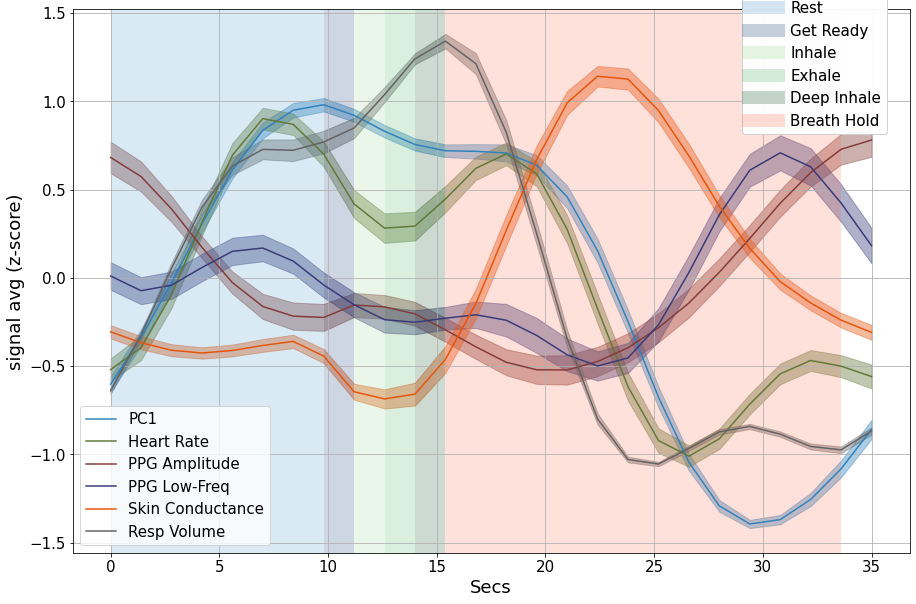

In [183]:
# select physio signals
physio_select = ['PC1', 'PPG_HR', 'PPG_PEAK_AMP', 'PPG_LOW', 'GSR', 'RSP_RVT']

# specify the # of volumes removed from the start of the func scan
n_trim=7

# get labels for physio signals
physio_labels = [physio_label_dict[p] for p in physio_select]

# define labels for blocks
block_dict = {
    'R': 'Rest',
    'G': 'Get Ready',
    'In': 'Inhale',
    'Out': 'Exhale',
    'Deep': 'Deep Inhale',
    'H': 'Breath Hold'
}

green_cmap = cm.get_cmap('Greens')
blue_cmap = cm.get_cmap('Blues')
red_cmap = cm.get_cmap('Reds')

norm = plt.Normalize(0, 100)
# define colors for blocks
color_block_dict = {
    'R': blue_cmap(norm(60)),
    'G': blue_cmap(norm(99)),
    'In': green_cmap(norm(40)),
    'Out': green_cmap(norm(60)),
    'Deep': green_cmap(norm(99)),
    'H': red_cmap(norm(50))
}

# load nki events and convert to blocks
nki_events = load_nki_event_file()
nki_events['block'] = (nki_events['trial_type'] == 'R').cumsum()
group_func = {'onset': 'first', 'duration': 'sum'}
block_df = nki_events.groupby('block').agg(group_func)
block_indx = onsets_to_block(block_df, params['nki']['tr'], 0)

# get block onsets and durations
blocks_df = nki_events.loc[nki_events.block == 1].copy()
h_blocks = [b for b in blocks_df.trial_type if b.startswith('H')]
blocks_df.loc[blocks_df.trial_type.isin(h_blocks), 'trial_type'] = 'H'
blocks_df = blocks_df.groupby('trial_type').agg(group_func)
blocks_df = blocks_df.sort_values(by='onset').reset_index()

# loop through subjects and trial average
physio_list = [[] for i in range(len(physio_select))]
subject, scan = load_subject_list('nki', params['nki']['subject_list'])
for subj, sc in zip(subject, scan):
    df = load_subj(subj, sc, 'nki', params['nki'], pca_dict['nki'][f'{subj}_{sc}'], 
                   pca_index=0)
    for i, p in enumerate(physio_select):
        if p == 'PC1':
            p_sig = zscore(df[p].values)[:,np.newaxis]*pca_sign_dict['nki']
        else:
            p_sig = zscore(df[p].values)[:,np.newaxis]
        # prepend lost volumes removed in preproc w/ zeros
        p_sig = np.vstack([np.zeros((n_trim, 1)), p_sig])
        p_sig_avg = np.squeeze(p_sig[block_indx,:].mean(axis=0))
        physio_list[i].append(p_sig_avg)

physio_avg_list = [np.mean(physio_list[i], axis=0) for i in range(len(physio_select))]

# get important parameters
n_t = len(physio_avg_list[0])
fs_nki = 1/params['nki']['tr']
n_secs = np.arange(n_t)/fs_nki

# Bootstrap standard errors
physio_array = np.array(physio_list, dtype='object') # makes indexing easier
n_subj = len(physio_list[0])
n_perms = 100
perms_avg = []
for i in range(n_perms):
    perm_sample = np.random.choice(np.arange(n_subj), n_subj)
    physio_trials_perm = [np.vstack(p[perm_sample]) for p in physio_array]
    perms_avg.append([np.mean(p_trials, axis=0) for p_trials in physio_trials_perm])

physio_se_list = []
for i, p in enumerate(physio_list):
    # the np.array call with dtype parameter because the 'object' dtype is carried forward
    # from physio_array
    perms_se = np.vstack([np.array(perm_i[i], dtype='float') for perm_i in perms_avg])
    physio_se_list.append(np.std(perms_se, axis=0))
    
fig, ax = plt.subplots(figsize=(15,10))
for i, (p_avg, p_se, p) in enumerate(zip(physio_avg_list, physio_se_list, physio_select)):
    ax.plot(n_secs, p_avg, color=color_dict[p])
    ax.fill_between(n_secs, p_avg-p_se, p_avg+p_se, alpha=0.4, color=color_dict[p])

# set legend for physio signals
lines = ax.get_lines()
legend1 = plt.legend([lines[i] for i in range(len(physio_select))], 
                     physio_labels, loc='lower left', fontsize=15)

# shade plot timespans according to block label
start_indx = 0
b_labels = []
b_colors = []
for i, (b, b_dur) in enumerate(zip(blocks_df.trial_type, blocks_df.duration)):
    b_dur_t = np.round(b_dur/params['nki']['tr'])
    blocks = np.arange(start_indx, start_indx+b_dur_t).astype(int)
    start_indx += b_dur_t
    b_labels.append(block_dict[b])
    b_colors.append(color_block_dict[b])
    ax.axvspan(n_secs[blocks[0]], n_secs[blocks[-1]]+params['nki']['tr'], 
               alpha=0.2, color=color_block_dict[b], lw=0)

# remove last inhalation block label (redundant with first block)
# last_inhale_indx = len(b_labels) - 1 - b_labels[::-1].index('Inhalation')
# del b_labels[last_inhale_indx]
# del b_colors[last_inhale_indx]
    
trial_leg_labels = [Line2D([0], [0], color=c, lw=13, alpha=0.2) for c in b_colors]

legend2 = plt.legend(trial_leg_labels, b_labels, 
                     loc=(0.8,0.77), fontsize=15)
ax.add_artist(legend1)
ax.add_artist(legend2)
ax.set_xlabel('Secs', fontsize=18)
ax.set_ylabel('signal avg (z-score)', fontsize=18)
ax.tick_params(axis='both', which='major', labelsize=15)
ax.grid(True)

plt.savefig('nki_breathhold.png', bbox_inches='tight')

## 8.4 Clamped CO2 vs. Free Breathing CPCA

### 8.4.1 Colorwheel

In [197]:
def convert_polar_xticks_to_radians(ax):
    # https://stackoverflow.com/questions/21172228/python-matplotlib-polar-plots-with-angular-labels-in-radians
    """
    Converts x-tick labels from degrees to radians
    """
    # Get the x-tick positions (returns in radians)
    label_positions = ax.get_xticks()
    # Convert to a list since we want to change the type of the elements
    labels = list(label_positions)
    # Format each label (edit this function however you'd like)
    labels = [format_radians_label(label) for label in labels]
    ax.set_xticklabels(labels)

def format_radians_label(float_in):
    # https://stackoverflow.com/questions/21172228/python-matplotlib-polar-plots-with-angular-labels-in-radians
    """ 
    Converts a float value in radians into a string representation of that float
    """
    string_out = str(float_in / (np.pi))+"π"
    
    return string_out

def colorwheel_pi(fig, axis, cmap):
    # Generate a colorwheel with a polar projection from 0 to 2pi
    axp = fig.add_axes(axis.get_position().bounds, polar=True, frameon=False)
    xval = np.arange(-3.14, 3.14, 0.01)
    yval = np.ones_like(xval)
    # Define colormap normalization for 0 to 2*pi
    norm = colors.Normalize(-np.pi, np.pi) 

    # Plot a color mesh on the polar plot
    # with the color set by the angle
    n = 200  #the number of secants for the mesh
    t = np.linspace(-np.pi,np.pi,100)   #theta values
    r = np.linspace(.7,1,2)        #radius values change 0.6 to 0 for full circle
    rg, tg = np.meshgrid(r,t)      #create a r,theta meshgrid
    c = tg                         #define color values as theta value
    axp.grid(False)
    im = axp.pcolormesh(t, r, c.T,norm=norm, cmap='twilight')  #plot the colormesh on axis with colormap
    axp.set_yticklabels([])                   #turn of radial tick labels (yticks)
    axp.tick_params(pad=30,labelsize=30)      #cosmetic changes to tick labels
    axp.spines['polar'].set_visible(False)    #turn off the axis spine.
    convert_polar_xticks_to_radians(axp)
    return axp


### 8.4.2 PC1 Spatial Maps

sizeof_hdr should be 348; set sizeof_hdr to 348
/var/folders/1h/7cb3drr10dz9ct35lt0qyds00000gn/T/ipykernel_6949/830575475.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels)


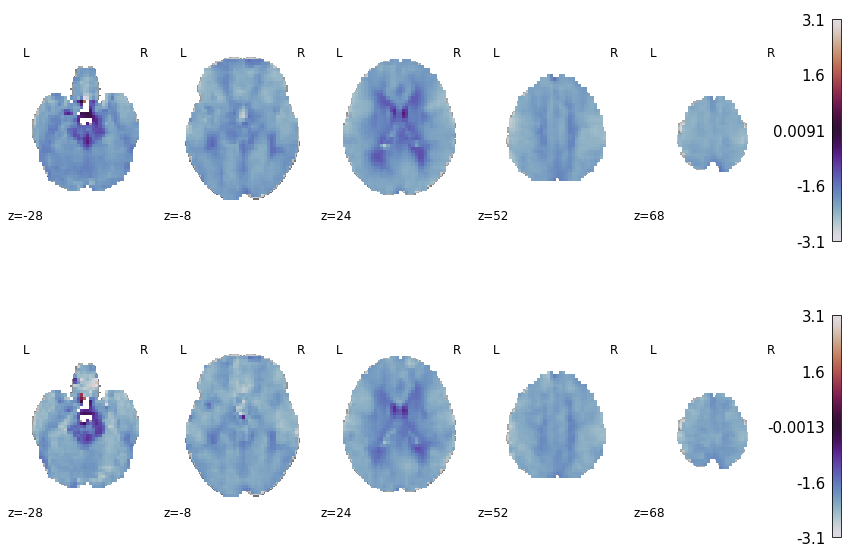

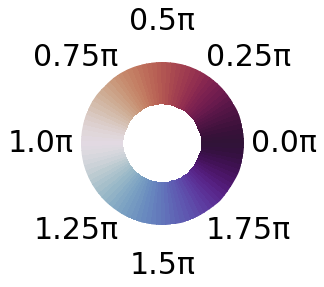

In [208]:
# get circular colormap
twilight_cmap = plt.get_cmap('twilight')

# load first complex principal component phase delay maps
nii_free_fp = 'results/pca/toronto_free_pca_c_ang.nii'
nii_clamped_fp = 'results/pca/toronto_clamped_pca_c_ang.nii'
mask = 'masks/MNI152_T1_4mm_brain_mask.nii.gz'

# load niftis w/ nibabel
nii_free = nb.load(nii_free_fp)
nii_clamped = nb.load(nii_clamped_fp)
mask_bin = nb.load(mask).get_fdata() > 0

# index nifti to select first complex principal component weights
cpc1_free = index_img(nii_free, 0)
cpc1_clamped = index_img(nii_clamped, 0)

# circular shift of clamped CO2 phase values to align with Free Breathing
data = cpc1_clamped.get_fdata()
data[mask_bin] += 3.5
data[mask_bin] = (data[mask_bin] - np.pi)%(np.pi-(-np.pi)) - np.pi
cpc1_clamped = nb.Nifti1Image(data, affine=nii_clamped.affine,
                             header=nii_clamped.header)
# plot first principal component weights for both conditions
fig, axs = plt.subplots(2,1, figsize=(15,10))

# manually define cuts of z-axis (axial slices)
z = [-28, -8, 24, 52, 68]

plotting.plot_stat_map(
    cpc1_free,
    display_mode="z",
    cut_coords=z,
    cmap='twilight',
    symmetric_cbar=False,
    axes=axs[0],
    
)

plotting.plot_stat_map(
    cpc1_clamped,
    display_mode="z",
    cut_coords=z,
    cmap='twilight',
    symmetric_cbar=False,
    axes=axs[1],
)

# increase cbar font size
cbar = fig.axes[7]
cbar.tick_params(labelsize=15)
cbar = fig.axes[-1]
cbar.tick_params(labelsize=15)


# Generate a figure with a polar projection
fig, ax = plt.subplots(figsize=(3,3))
colorwheel_pi(fig, ax, twilight_cmap)
ax.set_axis_off()
plt.show()

## 8.4 PPG Power Spectral Density

In [13]:
def load_raw_ppg(subj, dataset, fs=None, fs_resamp=None, scan=None):
    if (dataset == 'chang') | (dataset == 'chang_bh'):
        if dataset == 'chang':
            p_fp = f'data/dataset_chang/physio/raw/sub_00{subj}-mr_{scan}-ecr_echo1_physOUT.mat'
        elif dataset == 'chang_bh':
            p_fp = f'data/dataset_chang_bh/physio/raw/sub_00{subj}-mr_{scan}-adb_echo1_physOUT.mat'
        physio_raw = loadmat(p_fp, squeeze_me=True)
        fs = 1/physio_raw['OUT_p']['dt_phys'].item()
        ppg = physio_raw['OUT_p']['card_dat'].item()

    elif dataset == 'hcp':
        if fs is None:
            raise Exception('Sampling frequency - fs - must be supplied for HCP data')
        p_fp = f'data/dataset_hcp/physio/raw/{subj}_{scan}_physio.txt'
        physio_signals = np.loadtxt(p_fp)
        ppg = physio_signals[:,2]

    else:
        if dataset == 'spreng':
            p_fp = f'data/dataset_spreng/physio/raw/{subj}_{scan}_task-rest_physio.tsv.gz'
        elif dataset == 'nki':
            p_fp = f'data/dataset_nki/physio/raw/sub-{subj}_ses-{scan}_task-BREATHHOLD_acq-1400_physio.tsv.gz'
        elif dataset == 'nki_rest':
            p_fp = f'data/dataset_nki_rest/physio/raw/sub-{subj}_ses-{scan}_task-rest_acq-1400_physio.tsv.gz'
        
        subj_base = p_fp.rsplit('.tsv')[0]
        physio_json = json.load(open(f'{subj_base}.json'))
        physio_df = pd.read_csv(p_fp, compression='gzip', sep='\t', header=None)
        physio_df = physio_df.dropna(axis=1, how='all')
        fs = physio_json['SamplingFrequency']
        physio_df.columns = physio_json['Columns']
        ppg = physio_df['cardiac']

    if fs_resamp is not None:
        ppg = nk.signal_resample(
            ppg, sampling_rate=fs, desired_sampling_rate=fs_resamp, method='FFT'
        )
    return ppg

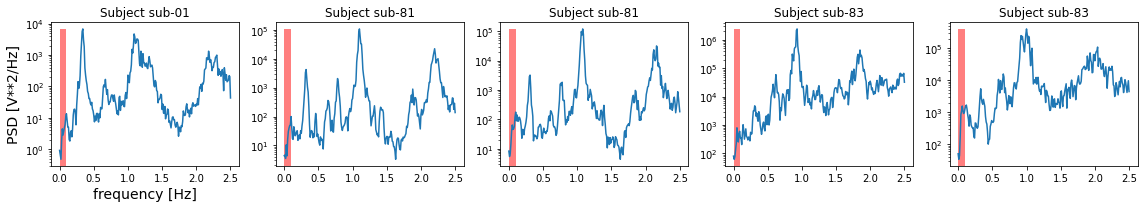

In [14]:
sf_resamp = 5 # resampling rate before power spectral density estimate

# chang, chang_bh, hcp, spreng, nki, nki_rest
dataset = 'spreng' # provide string of dataset

subject, scan = load_subject_list(dataset, params[dataset]['subject_list'])
if dataset == 'hcp':
    sf_dataset = 400 # HCP sf not in physio file, must manually specify
else:
    sf_dataset = None 

# Limit to 5 subjects for larger datasets
subject, scan = subject[:5], scan[:5]

fig, axs = plt.subplots(1,5, figsize=(16,3))
for i, (s, scan, ax) in enumerate(zip(subject, scan, axs.flat)):
    ppg = load_raw_ppg(s, dataset, fs=sf_dataset, 
                       fs_resamp=sf_resamp, scan=scan)

    f, pxx = welch(ppg, 5, nperseg=500, noverlap=50)
    ax.semilogy(f, pxx)
    if (dataset == 'chang') | (dataset == 'chang_bh'):
        ax.set_title(f'Subject {s} - Scan {scan}', fontsize=12)
    else:
        ax.set_title(f'Subject {s}', fontsize=12)

    if i == 0:
        ax.set_xlabel('frequency [Hz]', fontsize=14)
        ax.set_ylabel('PSD [V**2/Hz]', fontsize=14)
    f_low = f[f <= 0.1]
    ax.fill_between(f_low, 0, max(pxx), facecolor='red', alpha=0.5)

fig.tight_layout()
plt.show()

## 8.5 Example Time Courses

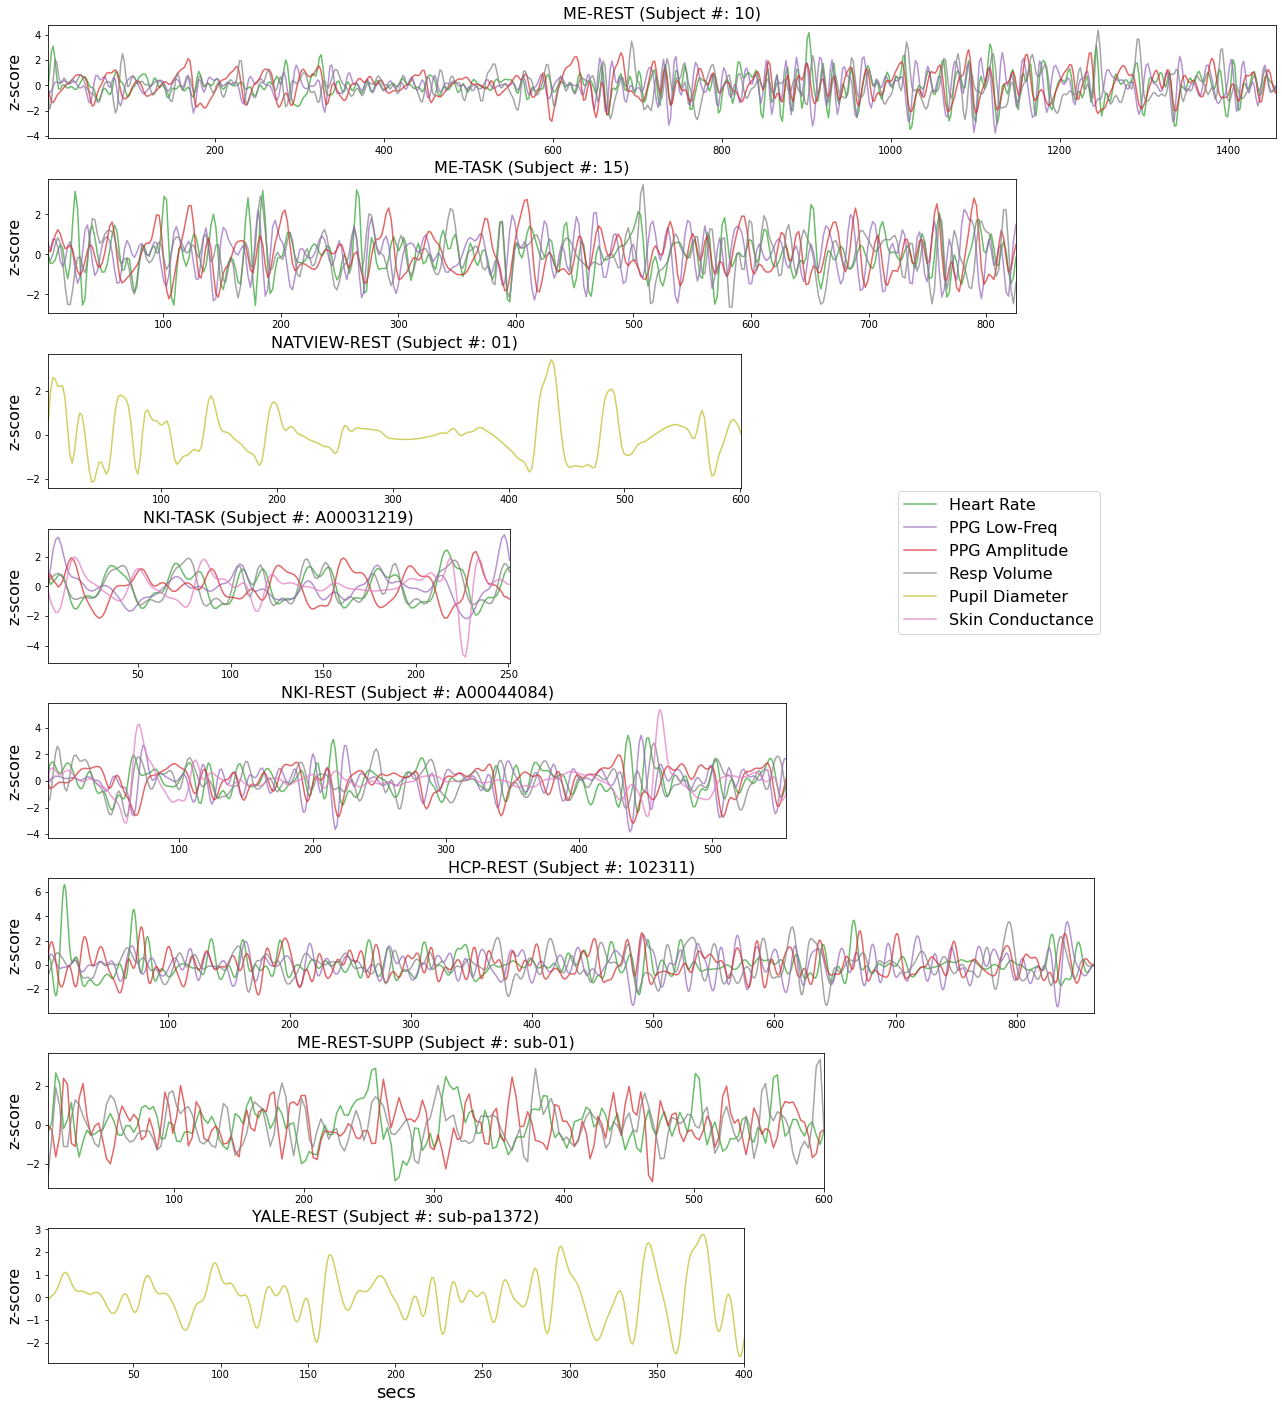

In [80]:
physio_dict = {
    'chang': ['PPG_HR', 'PPG_LOW', 'PPG_PEAK_AMP', 'RSP_RVT'],
    'chang_bh': ['PPG_HR', 'PPG_LOW', 'PPG_PEAK_AMP', 'RSP_RVT'],
    'natview': ['PUPIL'],
    'nki': ['PPG_HR', 'PPG_LOW' ,'PPG_PEAK_AMP', 'RSP_RVT', 'GSR'],
    'nki_rest': ['PPG_HR', 'PPG_LOW' ,'PPG_PEAK_AMP', 'RSP_RVT', 'GSR'],
    'hcp': ['PPG_HR', 'PPG_LOW', 'PPG_PEAK_AMP', 'RSP_RVT'],
    'spreng': ['PPG_HR', 'PPG_PEAK_AMP', 'RSP_RVT'],
    'yale': ['PUPIL']
}

dataset_aspect_dict = {
    'chang': 15,
    'chang_bh': 17,
    'natview': 19,
    'nki': 8,
    'nki_rest':10,
    'hcp': 10,
    'spreng': 15,
    'yale': 13
}

fig = plt.figure(figsize=(22,25), constrained_layout=False)
gspec = fig.add_gridspec(8,1, hspace=0.3, height_ratios=None)

for i, d in enumerate(physio_dict):
    subject, scan = load_subject_list(d, params[d]['subject_list'])
    # Load Subject
    df = load_subj(
        subject[0], scan[0], d, params[d],
        pca_dict[d][f'{subject[0]}_{scan[0]}'], pca_index=0
    )
    # flip sign for PC1, if necessary
    df['PC1'] = df['PC1'] * pca_sign_dict[d]
    # normalize data before concatenation
    df = df.apply(zscore, axis=0)

    ax = fig.add_subplot(gspec[i])
    ax.set_aspect(dataset_aspect_dict[d], anchor='SW')
    
    x = np.arange(1, df.shape[0]+1)*(params[d]['tr'])
    for p in physio_dict[d]:
        ax.plot(x, df[p].values, color=color_dict[p], alpha=0.7, label=physio_label_dict[p])
        ax.set_xlim(x[0], x[-1])
        
    ax.set_title(f'{dataset_label_dict[d]} (Subject #: {subject[0]})', fontsize=16)
    ax.set_ylabel('z-score', fontsize=16)
    if i == 7:
        ax.set_xlabel('secs', fontsize=18)
    
lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
lines = []
labels = []
label_list = []
for ax_lines in lines_labels:
    for line, label in zip(*ax_lines):
        if label not in label_list:
            lines.append(line)
            labels.append(label)
            label_list.append(label)
fig.legend(lines, labels, loc = (0.7,0.55), fontsize=16,
           bbox_transform = plt.gcf().transFigure)

## 8.6 Electrophysiological Preprocessing Flow Chart

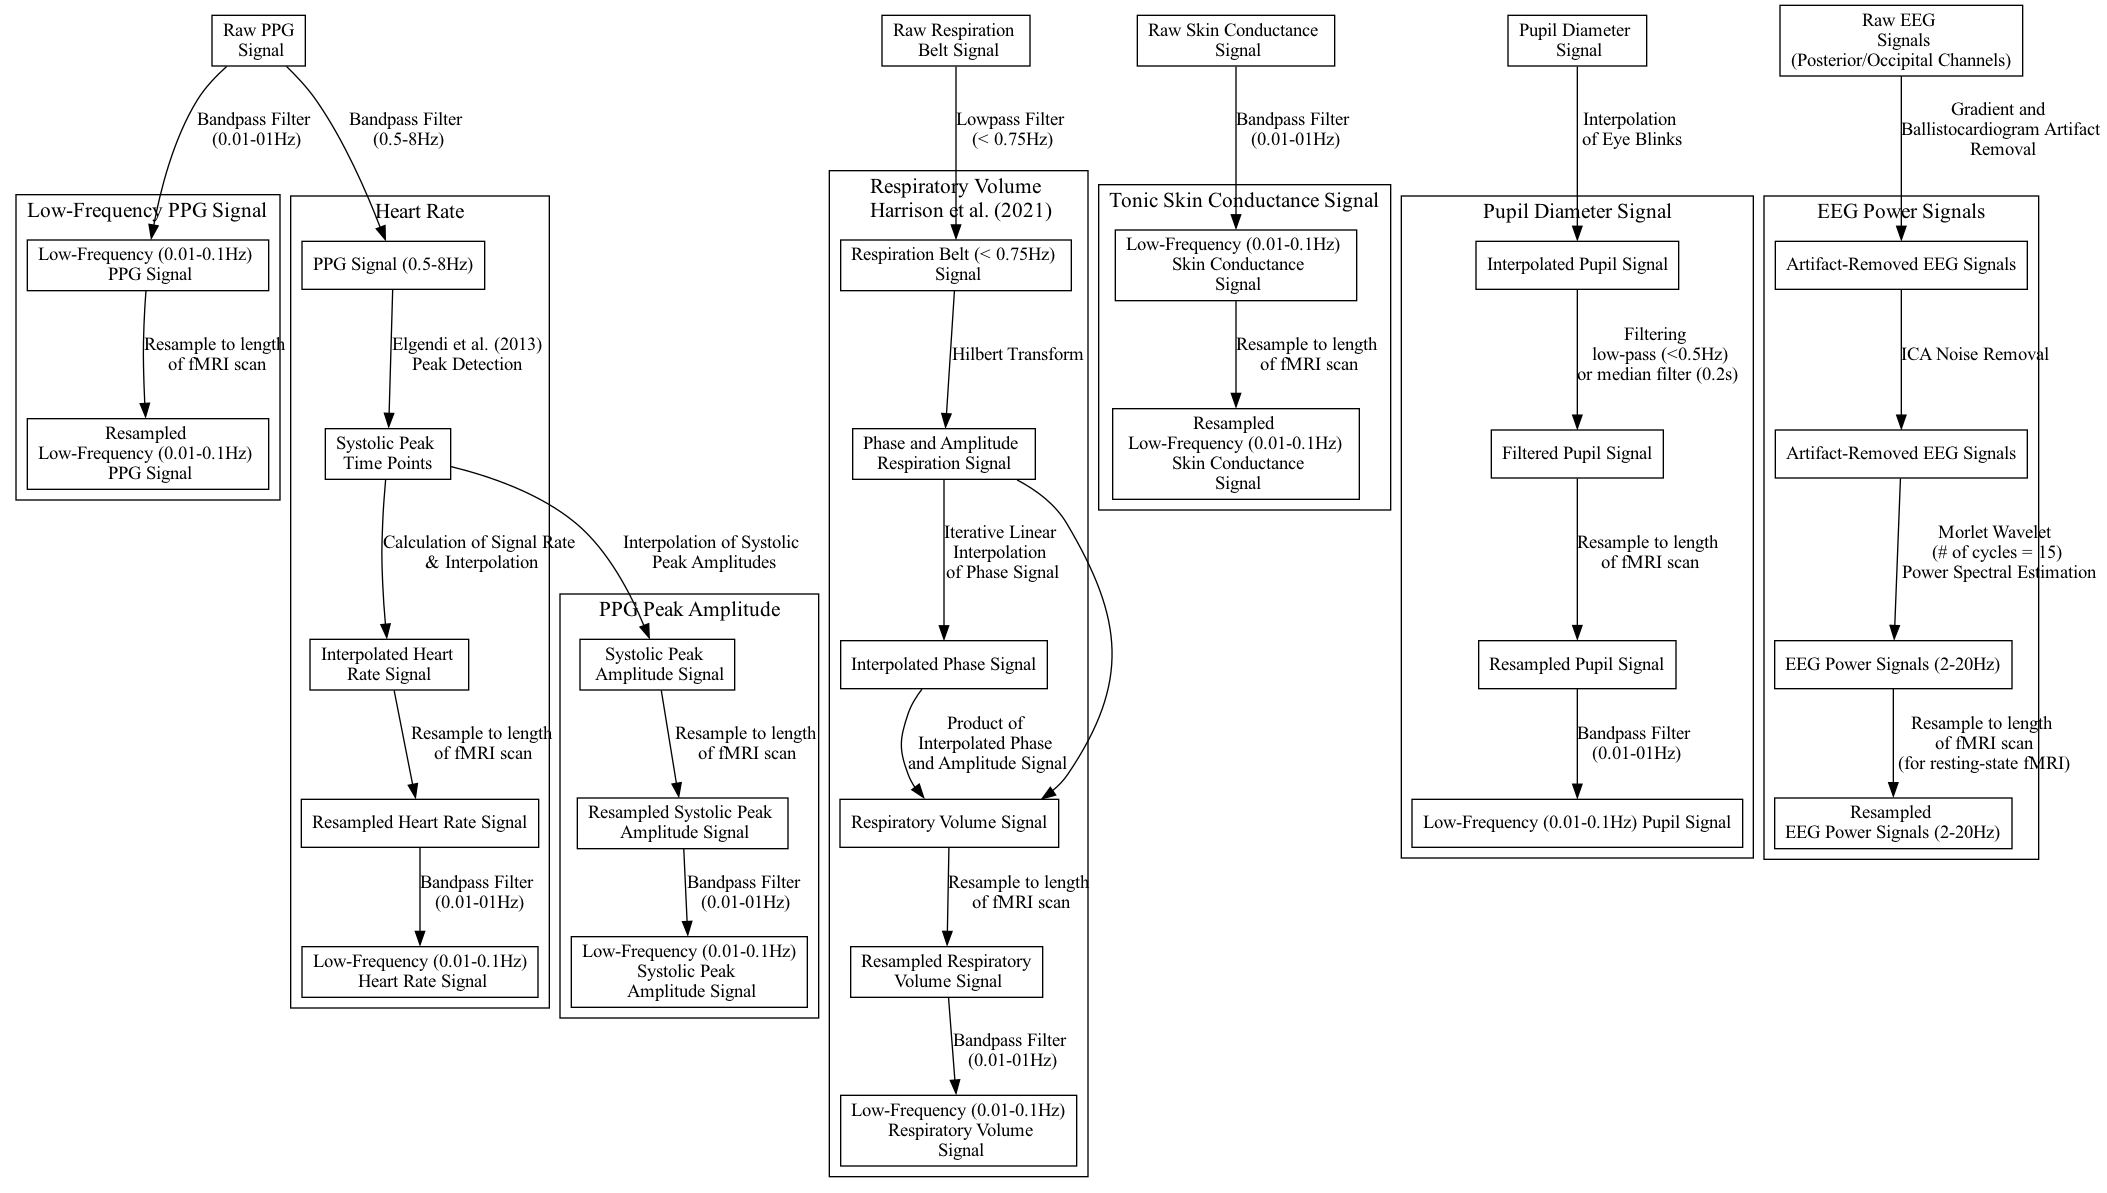

In [87]:
# The Pydot (pydot==1.4.2) package is not in the requirements.txt file, it's only needed for the following
# flowchart graphic
import pydot

from IPython.display import Image, display

def view_pydot(pdot):
    plt = Image(pdot.create_png())
    display(plt)
    
dot_graph = pydot.Dot(graph_type='digraph')

# Raw Signal Nodes
ppg_node = pydot.Node('RAW_PPG', label='Raw PPG\n Signal')
ppg_node.set_shape('box')
dot_graph.add_node(ppg_node)

resp_node = pydot.Node('RAW_RESP', label='Raw Respiration \n Belt Signal')
resp_node.set_shape('box')
dot_graph.add_node(resp_node)

gsr_node = pydot.Node('RAW_GSR', label='Raw Skin Conductance \n Signal')
gsr_node.set_shape('box')
dot_graph.add_node(gsr_node)

pupil_node = pydot.Node('RAW_PUPIL', label='Pupil Diameter \n Signal')
pupil_node.set_shape('box')
dot_graph.add_node(pupil_node)

eeg_node = pydot.Node(
    'RAW_EEG', 
    label='Raw EEG \n Signals'
    '\n(Posterior/Occipital Channels)'
)
eeg_node.set_shape('box')
dot_graph.add_node(eeg_node)


# Put separate pipelines into clusters
ppg_low_cluster=pydot.Cluster('PPG_LOW_CLUS', label='Low-Frequency PPG Signal', 
                              shape='rectangle', fontsize=16)
dot_graph.add_subgraph(ppg_low_cluster)

hr_cluster=pydot.Cluster('HR', label='Heart Rate',shape='rectangle', fontsize=16)
dot_graph.add_subgraph(hr_cluster)

ppg_amp_cluster=pydot.Cluster('PPG_PEAK', label='PPG Peak Amplitude', shape='rectangle', fontsize=16)
dot_graph.add_subgraph(ppg_amp_cluster)

resp_cluster=pydot.Cluster('RESP', label='Respiratory Volume \n Harrison et al. (2021)',
                           shape='rectangle', fontsize=16)
dot_graph.add_subgraph(resp_cluster)

gsr_cluster=pydot.Cluster('GSR', label='Tonic Skin Conductance Signal',
                           shape='rectangle', fontsize=16)
dot_graph.add_subgraph(gsr_cluster)

pupil_cluster=pydot.Cluster('PUPIL', label='Pupil Diameter Signal',
                           shape='rectangle', fontsize=16)
dot_graph.add_subgraph(pupil_cluster)

eeg_cluster=pydot.Cluster('EEG', label='EEG Power Signals',
                           shape='rectangle', fontsize=16)
dot_graph.add_subgraph(eeg_cluster)

# First Preprocessing Nodes
ppg_low_node = pydot.Node('PPG_LOW', label='Low-Frequency (0.01-0.1Hz) \n PPG Signal')
ppg_low_node.set_shape('box')
ppg_low_cluster.add_node(ppg_low_node)
ppg_edge_low = pydot.Edge('RAW_PPG', 'PPG_LOW', label='Bandpass Filter \n(0.01-01Hz)')
dot_graph.add_edge(ppg_edge_low)

ppg_proc1_node = pydot.Node('PROC1_PPG', label='PPG Signal (0.5-8Hz)')
ppg_proc1_node.set_shape('box')
hr_cluster.add_node(ppg_proc1_node)
ppg_edge1 = pydot.Edge('RAW_PPG', 'PROC1_PPG', label='Bandpass Filter \n(0.5-8Hz)')
dot_graph.add_edge(ppg_edge1)

resp_proc1_node = pydot.Node('PROC1_RESP', label='Respiration Belt (< 0.75Hz) \n Signal')
resp_proc1_node.set_shape('box')
resp_cluster.add_node(resp_proc1_node)
resp_edge1 = pydot.Edge('RAW_RESP', 'PROC1_RESP', label='Lowpass Filter \n(< 0.75Hz)')
dot_graph.add_edge(resp_edge1)

gsr_proc1_node = pydot.Node('PROC1_GSR', label='Low-Frequency (0.01-0.1Hz) \n Skin Conductance\n Signal')
gsr_proc1_node.set_shape('box')
gsr_cluster.add_node(gsr_proc1_node)
gsr_edge1 = pydot.Edge('RAW_GSR', 'PROC1_GSR', label='Bandpass Filter \n(0.01-01Hz)')
dot_graph.add_edge(gsr_edge1)

pupil_proc1_node = pydot.Node('PROC1_PUPIL', label='Interpolated Pupil Signal')
pupil_proc1_node.set_shape('box')
pupil_cluster.add_node(pupil_proc1_node)
pupil_edge1 = pydot.Edge('RAW_PUPIL', 'PROC1_PUPIL', label='Interpolation\n of Eye Blinks')
dot_graph.add_edge(pupil_edge1)

eeg_proc1_node = pydot.Node('PROC1_EEG', label='Artifact-Removed EEG Signals')
eeg_proc1_node.set_shape('box')
eeg_cluster.add_node(eeg_proc1_node)
eeg_edge1 = pydot.Edge('RAW_EEG', 'PROC1_EEG', label='Gradient and \nBallistocardiogram Artifact\n Removal')
dot_graph.add_edge(eeg_edge1)

# Second Preprocessing Nodes
ppg_proc2_node = pydot.Node('PROC2_PPG', label='Systolic Peak \nTime Points')
ppg_proc2_node.set_shape('box')
hr_cluster.add_node(ppg_proc2_node)
ppg_edge2 = pydot.Edge('PROC1_PPG', 'PROC2_PPG', label='Elgendi et al. (2013)\nPeak Detection')
dot_graph.add_edge(ppg_edge2)

ppg_low_proc1_node = pydot.Node('PROC1_PPG_LOW', label='Resampled \nLow-Frequency (0.01-0.1Hz) \n PPG Signal')
ppg_low_proc1_node.set_shape('box')
ppg_low_cluster.add_node(ppg_low_proc1_node)
ppg_edge_low2 = pydot.Edge('PPG_LOW', 'PROC1_PPG_LOW', label='Resample to length\n of fMRI scan')
dot_graph.add_edge(ppg_edge_low2)

resp_proc2_node = pydot.Node('PROC2_RESP', label='Phase and Amplitude \nRespiration Signal')
resp_proc2_node.set_shape('box')
resp_cluster.add_node(resp_proc2_node)
resp_edge2 = pydot.Edge('PROC1_RESP', 'PROC2_RESP', label='Hilbert Transform')
dot_graph.add_edge(resp_edge2)

gsr_proc2_node = pydot.Node('PROC2_GSR', label='Resampled \n Low-Frequency (0.01-0.1Hz) \n Skin Conductance\n Signal')
gsr_proc2_node.set_shape('box')
gsr_cluster.add_node(gsr_proc2_node)
gsr_edge2 = pydot.Edge('PROC1_GSR', 'PROC2_GSR', label='Resample to length\n of fMRI scan')
dot_graph.add_edge(gsr_edge2)

pupil_proc2_node = pydot.Node('PROC2_PUPIL', label='Filtered Pupil Signal')
pupil_proc2_node.set_shape('box')
pupil_cluster.add_node(pupil_proc2_node)
pupil_edge2 = pydot.Edge(
    'PROC1_PUPIL', 'PROC2_PUPIL', label='Filtering \n low-pass (<0.5Hz)\nor median filter (0.2s)')
dot_graph.add_edge(pupil_edge2)

eeg_proc2_node = pydot.Node('PROC2_EEG', label='Artifact-Removed EEG Signals')
eeg_proc2_node.set_shape('box')
eeg_cluster.add_node(eeg_proc2_node)
eeg_edge2 = pydot.Edge('PROC1_EEG', 'PROC2_EEG', label='ICA Noise Removal')
dot_graph.add_edge(eeg_edge2)

# Third Preprocessing Nodes
ppg_proc3_node = pydot.Node('PROC3_PPG', label='Interpolated Heart \nRate Signal')
ppg_proc3_node.set_shape('box')
hr_cluster.add_node(ppg_proc3_node)
ppg_edge3 = pydot.Edge('PROC2_PPG', 'PROC3_PPG', label='Calculation of Signal Rate\n & Interpolation')
dot_graph.add_edge(ppg_edge3)

ppg_amp_proc3_node = pydot.Node('PROC3_AMP_PPG', label='Systolic Peak \n Amplitude Signal')
ppg_amp_proc3_node.set_shape('box')
ppg_amp_cluster.add_node(ppg_amp_proc3_node)
ppg_amp_edge3 = pydot.Edge('PROC2_PPG', 'PROC3_AMP_PPG', label='Interpolation of Systolic\n Peak Amplitudes')
dot_graph.add_edge(ppg_amp_edge3)

resp_proc3_node = pydot.Node('PROC3_RESP', label='Interpolated Phase Signal')
resp_proc3_node.set_shape('box')
resp_cluster.add_node(resp_proc3_node)
resp_edge3 = pydot.Edge('PROC2_RESP', 'PROC3_RESP', label='Iterative Linear \nInterpolation \nof Phase Signal')
dot_graph.add_edge(resp_edge3)

pupil_proc3_node = pydot.Node('PROC3_PUPIL', label='Resampled Pupil Signal')
pupil_proc3_node.set_shape('box')
pupil_cluster.add_node(pupil_proc3_node)
pupil_edge3 = pydot.Edge('PROC2_PUPIL', 'PROC3_PUPIL', label='Resample to length\n of fMRI scan')
dot_graph.add_edge(pupil_edge3)

eeg_proc3_node = pydot.Node('PROC3_EEG', label='EEG Power Signals (2-20Hz)')
eeg_proc3_node.set_shape('box')
eeg_cluster.add_node(eeg_proc3_node)
eeg_edge3 = pydot.Edge('PROC2_EEG', 'PROC3_EEG', label='Morlet Wavelet \n(# of cycles = 15)\n Power Spectral Estimation')
dot_graph.add_edge(eeg_edge3)

# Fourth Preprocessing Nodes
ppg_proc4_node = pydot.Node('PROC4_PPG', label='Resampled Heart Rate Signal')
ppg_proc4_node.set_shape('box')
hr_cluster.add_node(ppg_proc4_node)
ppg_edge4 = pydot.Edge('PROC3_PPG', 'PROC4_PPG', label='Resample to length\n of fMRI scan')
dot_graph.add_edge(ppg_edge4)

ppg_amp_proc4_node = pydot.Node('PROC4_AMP_PPG', label='Resampled Systolic Peak \n Amplitude Signal')
ppg_amp_proc4_node.set_shape('box')
ppg_amp_cluster.add_node(ppg_amp_proc4_node)
ppg_amp_edge4 = pydot.Edge('PROC3_AMP_PPG', 'PROC4_AMP_PPG', label='Resample to length\n of fMRI scan')
dot_graph.add_edge(ppg_amp_edge4)

resp_proc4_node = pydot.Node('PROC4_RESP', label='Respiratory Volume Signal')
resp_proc4_node.set_shape('box')
resp_cluster.add_node(resp_proc4_node)
resp_edge4_1 = pydot.Edge('PROC3_RESP', 'PROC4_RESP', 
                        label='Product of \nInterpolated Phase \nand Amplitude Signal')
resp_edge4_2 = pydot.Edge('PROC2_RESP', 'PROC4_RESP')
dot_graph.add_edge(resp_edge4_1)
dot_graph.add_edge(resp_edge4_2)

pupil_proc4_node = pydot.Node('PROC4_PUPIL', label='Low-Frequency (0.01-0.1Hz) Pupil Signal')
pupil_proc4_node.set_shape('box')
pupil_cluster.add_node(pupil_proc4_node)
pupil_edge4 = pydot.Edge('PROC3_PUPIL', 'PROC4_PUPIL', label='Bandpass Filter \n(0.01-01Hz)')
dot_graph.add_edge(pupil_edge4)

eeg_proc4_node = pydot.Node('PROC4_EEG', label='Resampled \nEEG Power Signals (2-20Hz)')
eeg_proc4_node.set_shape('box')
eeg_cluster.add_node(eeg_proc4_node)
eeg_edge4 = pydot.Edge('PROC3_EEG', 'PROC4_EEG', 
                       label='Resample to length\n of fMRI scan\n (for resting-state fMRI)')
dot_graph.add_edge(eeg_edge4)

# Fifth Preprocessing Nodes
ppg_proc5_node = pydot.Node('PROC5_PPG', label='Low-Frequency (0.01-0.1Hz)\n Heart Rate Signal')
ppg_proc5_node.set_shape('box')
hr_cluster.add_node(ppg_proc5_node)
ppg_edge5 = pydot.Edge('PROC4_PPG', 'PROC5_PPG', label='Bandpass Filter \n(0.01-01Hz)')
dot_graph.add_edge(ppg_edge5)

ppg_amp_proc5_node = pydot.Node('PROC5_AMP_PPG', label='Low-Frequency (0.01-0.1Hz)\nSystolic Peak \n Amplitude Signal')
ppg_amp_proc5_node.set_shape('box')
ppg_amp_cluster.add_node(ppg_amp_proc5_node)
ppg_amp_edge5 = pydot.Edge('PROC4_AMP_PPG', 'PROC5_AMP_PPG', label='Bandpass Filter \n(0.01-01Hz)')
dot_graph.add_edge(ppg_amp_edge5)

resp_proc5_node = pydot.Node('PROC5_RESP', label='Resampled Respiratory\n Volume Signal')
resp_proc5_node.set_shape('box')
resp_cluster.add_node(resp_proc5_node)
resp_edge5 = pydot.Edge('PROC4_RESP', 'PROC5_RESP', label='Resample to length\n of fMRI scan')
dot_graph.add_edge(resp_edge5)

# Sixth Preprocessing Node
resp_proc6_node = pydot.Node('PROC6_RESP', label='Low-Frequency (0.01-0.1Hz)\n Respiratory Volume\n Signal')
resp_proc6_node.set_shape('box')
resp_cluster.add_node(resp_proc6_node)
resp_edge6 = pydot.Edge('PROC5_RESP', 'PROC6_RESP', label='Bandpass Filter \n(0.01-01Hz)')
dot_graph.add_edge(resp_edge6)

view_pydot(dot_graph)

## 8.7 Multi-Set CCA Simulation

### 8.7.1 Fit MCCA

[0.85676061 0.82940959 0.14325057 0.0647584 ]
[-1.55460701 -1.55647381]


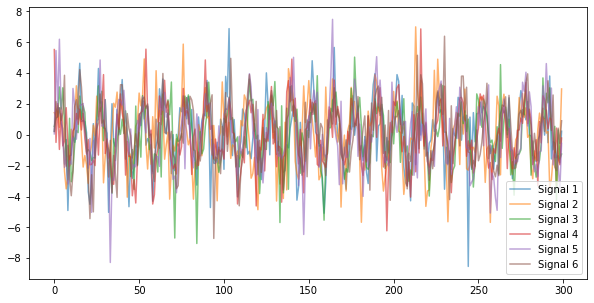

In [6]:
# Signal Parameters
n_signals = 6
amplitude = 2
noise = 1
freq = 0.08
phase_shift_range = [0, np.pi/2]
duration = 300
sampling_rate = 1

np.random.seed(1)
# Lag Basis Spline Parameters
lag_vec = np.arange(10+1)
spline_df=4

n_samples = int(np.rint(duration * sampling_rate))
x = np.arange(n_samples) * (1/sampling_rate)
phase_shift = np.random.uniform(phase_shift_range[0],phase_shift_range[1], n_signals)

signal_list = []
for i, p in enumerate(phase_shift):
    signal = amplitude * np.sin(2 * np.pi * freq * x + p)
    signal += np.random.laplace(0, noise, len(x))
    signal_series = pd.Series(signal, name=f'Signal_{i}')
    signal_list.append(signal_series)

fig, ax = plt.subplots(figsize=(10,5))
signal_labels = [f'Signal {i+1}' for i in range(n_signals)]
for i, signal in enumerate(signal_list):
    ax.plot(signal, label=signal_labels[i], alpha=0.6)
ax.legend()
    
signal_basis = []
signal_trim = []
for signal in signal_list:
    basis, lag_spline = lag_basis(signal, lag_vec, spline_df)
    # Trim NaNs introduced from lag splines
    na_indx = ~(np.isnan(basis).any(axis=1))
    signal_basis.append(basis[na_indx, :])
    signal_trim.append(signal[na_indx])

# Fit MCCA
mcca = MCCA(latent_dims=4, random_state=0)
mcca.fit(signal_basis)

# Print average pair-wise correlation
print(mcca.score(signal_basis))

# Correlation matrix
corr_mat = mcca.correlations(signal_basis)

# Get canonical components
cca_pred = mcca.transform(signal_basis)

# Get phase shift between first and second CCA comp
pred_signal1 = cca_pred[2][:,0]
pred_signal2 = cca_pred[2][:,1]

f, pxy = csd(pred_signal1, pred_signal2, 1, return_onesided=True)
f_indx = np.where( (f>(freq - 0.005)) & (f< (freq + 0.005)) ) 
print(np.angle(pxy)[f_indx])

### 8.7.2 Illustrate MCCA

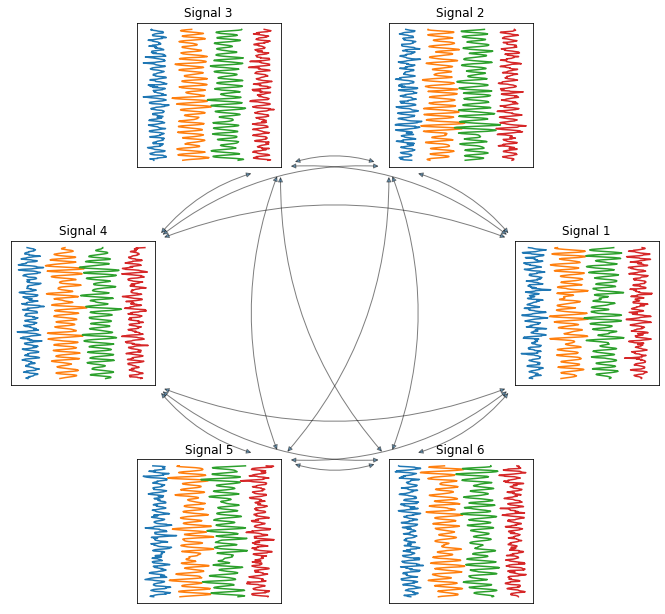

In [371]:
# Signal Parameters
N = 6
t = np.linspace(0,2*np.pi, N, endpoint=False)
r = 0.35
h = 0.9 - 2*r
w = h
X,Y = r*np.cos(t)-w/2.+ 0.5, r*np.sin(t)-h/2.+ 0.5

fig = plt.figure(figsize=(10,10))

signal_labels = [f'Signal {i+1}' for i in range(n_signals)]
axes = []
for i, (x,y) in enumerate(zip(X,Y)):
    ax = fig.add_axes([x, y, w, h])
    ax.plot(signal_basis[i][:,0]/10, np.arange(signal_basis[i].shape[0])[::-1])
    ax.plot(signal_basis[i][:,1]/10 + 2, np.arange(signal_basis[i].shape[0])[::-1])
    ax.plot(signal_basis[i][:,2]/10 + 4, np.arange(signal_basis[i].shape[0])[::-1])
    ax.plot(signal_basis[i][:,3]/10 + 6, np.arange(signal_basis[i].shape[0])[::-1])
    ax.set_title(signal_labels[i], fontsize=12)
    ax.set_xticks([])
    ax.set_yticks([])
    axes.append(ax)

    
node_paths = {
    1: {
        2: [(0,1), (0,0), (10,30)],
        3: [(0,1), (1,0), (10,10)],
        4: [(0,1), (1,1), (10,10)],
        5: [()],
    },
    2: {
        3: [(0,0), (1,0), (15,15)],
        4: [(0,0), (1,1), (10,10)],
        6: [()]
    },
    3: {
        4: [(1,0), (1,1), (30,10)],
        5: [(1,0), (1,1), (10,10)],
        6: [(1,0), (0,1), (10,10)]
    },
    4: {
        1: [(1,0), (0,0), (10,10)],
        5: [(1,0), (1,1), (10,30)],
        6: [(1,0), (0,1), (10,10)]
    },
    5: {
        1: [(1,1), (0,0), (10,10)],
        2: [(1,1), (0,0), (10,10)],
        6: [(1,1), (0,1), (15,15)]
    },
    6: {
        1: [(0,1), (0,0), (30,10)],
        2: [(0,1), (0,0), (10,10)]
    }
}

edges = [(1,2), (1,3), (1,4), (2,3), (2,4), (3,4), (3,5), (3,6),
        (4,1), (4,5), (4,6), (5,1), (5,2), (5,6), (6,1), (6,2)]

for node_path in edges:
    i, j = node_path[0], node_path[1]
    con = ConnectionPatch(
        xyA=node_paths[i][j][0], coordsA=axes[i-1].transAxes,
        xyB=node_paths[i][j][1], coordsB=axes[j-1].transAxes, 
        shrinkA=node_paths[i][j][2][0], shrinkB=node_paths[i][j][2][1],
        connectionstyle='arc3, rad=.2', arrowstyle="<|-|>", alpha=0.5)
    axes[0].add_artist(con)



plt.show()

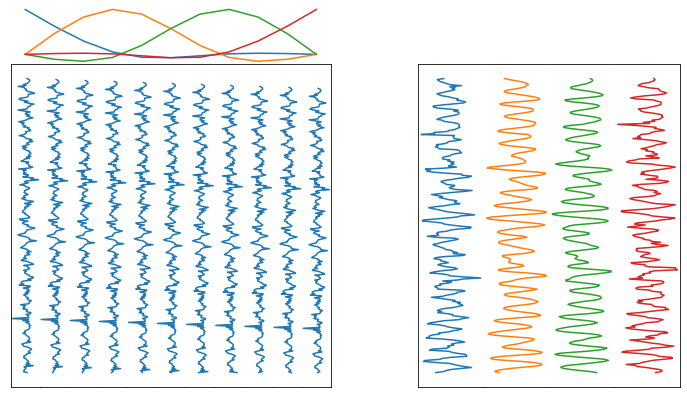

In [366]:
# Grab simulated signal
signal = signal_list[0]
signal_b = signal_basis[0]

# Start figure creation
fig = plt.figure(figsize=(12,7), constrained_layout=False)
gspec = fig.add_gridspec(1,2, wspace=0.3, width_ratios=[0.55, 0.45])

gsub1 = gspec[0].subgridspec(2,1, hspace=0, height_ratios=[0.15,0.85])

gsub1_1 = gsub1[1,0].subgridspec(1,11, wspace=0)
# Lag Basis Spline Parameters
lag_vec = np.arange(10+1)
lag_nknots=4

for i, l in enumerate(lag_vec):
    if i > 0:
        ax = fig.add_subplot(gsub1_1[i], sharey=ax)
    else:
        ax = fig.add_subplot(gsub1_1[i])
    ax.plot(signal.shift(i), np.arange(len(signal)))
    if i > 0:
        ax.set_xticks([])
        ax.set_yticks([])
    else:
        ax.set_xticks([])
    
    if (i > 0) & (i < (len(lag_vec)-1)):
        ax.spines.right.set_visible(False)
        ax.spines.left.set_visible(False)
    elif i == (len(lag_vec)-1):
        ax.spines.left.set_visible(False)
    plt.gca().invert_yaxis()

basis_lag = dmatrix("cr(x, df=4) - 1", {"x": lag_vec}, return_type='dataframe')
ax = fig.add_subplot(gsub1[0])
for i in range(basis_lag.shape[1]):
    ax.plot(basis_lag.iloc[:,i])
ax.axis('off')

gsub2 = gspec[1].subgridspec(2,1, hspace=0, height_ratios=[0.15,0.85])

gsub2_1 = gsub2[1].subgridspec(1, signal_b.shape[1], wspace=0)
cmap = plt.get_cmap('tab10')
color_vec = [cmap(i) for i in range(signal_b.shape[1])]
for i in range(signal_b.shape[1]):
    if i > 0:
        ax = fig.add_subplot(gsub2_1[i], sharey=ax)
    else:
        ax = fig.add_subplot(gsub2_1[i])
    ax.plot(signal_b[:,i], np.arange(len(signal_b)), color=color_vec[i])
    if i > 0:
        ax.set_xticks([])
        ax.set_yticks([])
    else:
        ax.set_xticks([])
    
    if (i > 0) & (i < (signal_b.shape[1]-1)):
        ax.spines.right.set_visible(False)
        ax.spines.left.set_visible(False)
    elif i == (signal_b.shape[1]-1):
        ax.spines.left.set_visible(False)
    plt.gca().invert_yaxis()

# 9. Misc

## 9.1 K-Complex Detection 

K-complex detection was performed on a sub-sample of the ME-REST dataset who fell asleep (as visible from their EEG montage). K-complex detection was performed semi-automatically with the Python package yasa (https://github.com/raphaelvallat/yasa). This package is not listed in the requirements.txt file, so it must be pip installed separately. For visualizing and annotating the EEG montage, you need to have the pyqtgraph MNE backend installed (https://github.com/mne-tools/mne-qt-browser).

The K-Complex pipeline operates in three stages. First, automated sleep staging was performed on the C3 channel. Second, the estimated sleep stages and the multi-channel EEG time courses were input to the a slow-wave detection algorithm (detection was only performed on N2 stages). Third, the candidate K-complexes were removed/retained from manual inspection. The onsets of the resulting K-complexes were then used for event-related averaging of physiological time courses.

The cell below illustrates the K-complex detection pipeline with an example subject.

### 9.1.1 Preprocessing

In [1]:
import mne
import numpy as np
import pandas as pd
import yasa

from scipy.io import loadmat
from scipy.stats import zscore
# example subject fp
fp = 'data/dataset_chang/eeg/raw/sub_0010-mr_0009_eeg_pp.mat'
# load data
eeg_mat = loadmat(fp, squeeze_me=True)
sf = eeg_mat['EEG']['srate'].item()
n_chan = eeg_mat['EEG']['nbchan'].item()
chan_labels = [chan[0] for chan in eeg_mat['EEG']['chanlocs'].item()]
info = mne.create_info(chan_labels, ch_types='eeg', sfreq=sf)
data = np.vstack(eeg_mat['EEG']['data'].item())
eeg_mne = mne.io.RawArray(data, info, verbose=False)
# convert from uV to V
eeg_mne.apply_function(lambda x: x * 1e-6)
# Trim off first 14.7s to align w/ functional (first 7 TRs were trimmed from functional)
eeg_mne.crop(tmin=14.7)
# select frontal and central channels
sls_chs = ['Fp1','Fp2','F3','F4','C3','C4','FC1',
           'FC2', 'F7', 'F8', 'Cz', 'FC5', 'FC6']
eeg_mne_fc = eeg_mne.copy()
eeg_mne_fc.pick(sls_chs)

# perform sleep staging across channels
sls_pred = []
for ch in sls_chs:
    sls = yasa.SleepStaging(eeg_mne_fc, eeg_name=ch)
    sls_pred.append(sls.predict())

# select most frequent sleep stage across channels
hypno = pd.DataFrame(sls_pred, index=sls_chs).T.mode(axis=1)[0].values.tolist()
# map sleep stage to integer codes required by sw_detect
hypno_remap = {
    'W': 0,
    'N1': 1,
    'N2': 2,
    'N3': 3,
    'R': 4
}
hypno_int = [hypno_remap[h] for h in hypno]
# upsample hypnogram from 30s window to eeg sampling frequency
hypno_up = yasa.hypno_upsample_to_data(hypno_int, 1/30, eeg_mne)

# add annotations from hypnogram
hypno_change = np.where(np.diff(hypno_up, prepend=1) != 0)[0]
hypno_remap_r = {v: k for k,v in hypno_remap.items()}
hypno_change_t = [eeg_mne.times[i] for i in hypno_change]
hypno_change_l = [hypno_remap_r[h] for h in hypno_up[hypno_change]]
annot = mne.Annotations(
    hypno_change_t,
    10,
    hypno_change_l
)

# set annotations
eeg_mne.set_annotations(annot)
eeg_mne_fc.set_annotations(annot)

print(eeg_mne)

/Users/taylorbolt/opt/miniconda3/envs/eeg_fmri/lib/python3.9/site-packages/antropy/fractal.py:197: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @jit('float64(float64[:], int32)')
/Users/taylorbolt/opt/miniconda3/envs/eeg_fmri/lib/python3.9/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package outdated is out of date. Your version is 0.2.1, the latest is 0.2.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(
/Users/taylorbolt/opt/miniconda3/envs/eeg_fmri/lib/python3.9/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package yasa is out of date. Your version is 0.6.3, the latest is 0.6.4.
Set the envir

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/Users/taylorbolt/opt/miniconda3/envs/eeg_fmri/lib/python3.9/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator LabelEncoder from version 0.24.2 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Users/taylorbolt/opt/miniconda3/envs/eeg_fmri/lib/python3.9/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator LabelEncoder from version 0.24.2 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/Users/taylorbolt/opt/miniconda3/envs/eeg_fmri/lib/python3.9/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator LabelEncoder from version 0.24.2 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Users/taylorbolt/opt/miniconda3/envs/eeg_fmri/lib/python3.9/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator LabelEncoder from version 0.24.2 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/Users/taylorbolt/opt/miniconda3/envs/eeg_fmri/lib/python3.9/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator LabelEncoder from version 0.24.2 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Users/taylorbolt/opt/miniconda3/envs/eeg_fmri/lib/python3.9/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator LabelEncoder from version 0.24.2 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/Users/taylorbolt/opt/miniconda3/envs/eeg_fmri/lib/python3.9/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator LabelEncoder from version 0.24.2 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Users/taylorbolt/opt/miniconda3/envs/eeg_fmri/lib/python3.9/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator LabelEncoder from version 0.24.2 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/Users/taylorbolt/opt/miniconda3/envs/eeg_fmri/lib/python3.9/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator LabelEncoder from version 0.24.2 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Users/taylorbolt/opt/miniconda3/envs/eeg_fmri/lib/python3.9/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator LabelEncoder from version 0.24.2 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/Users/taylorbolt/opt/miniconda3/envs/eeg_fmri/lib/python3.9/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator LabelEncoder from version 0.24.2 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Users/taylorbolt/opt/miniconda3/envs/eeg_fmri/lib/python3.9/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator LabelEncoder from version 0.24.2 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Users/taylorbolt/opt/miniconda3/envs/eeg_fmri/lib/python3.9/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle est

<RawArray | 31 x 363824 (1455.3 s), ~86.1 MB, data loaded>


### 9.1.2 Visualization in MNE-Python GUI

In [4]:
%gui qt

# custom bipolar referencing scheme
custom_reference = [
    # S1
    ('Fp1','F7'),
    ('F7', 'T7'),
    ('T7', 'P7'),
    ('P7', 'O1'),
    # S2
    ('Fp1', 'F3'),
    ('F3', 'C3'),
    ('C3' ,'P3'),
    ('P3', 'O1'),
    # S3
    ('Fz', 'Cz'),
    ('Cz', 'Pz'),
    # S4
    ('Fp2', 'F4'),
    ('F4', 'C4'),
    ('C4' ,'P4'),
    ('P4', 'O2'),
    # S5
    ('Fp2', 'F8'),
    ('F8', 'T8'),
    ('T8', 'P8'),
    ('P8', 'O2')
]

ano = [c[0] for c in custom_reference 
       if (c[0] in eeg_mne.ch_names) and 
       (c[1] in eeg_mne.ch_names)]
cat = [c[1] for c in custom_reference
       if (c[0] in eeg_mne.ch_names) and 
       (c[1] in eeg_mne.ch_names)]
# set bipolar reference
eeg_mne_bi = mne.set_bipolar_reference(eeg_mne, anode=ano, cathode=cat)
bi_chan = [f'{c[0]}-{c[1]}' for c in custom_reference 
           if (c[0] in ano) and (c[1] in cat)]
eeg_mne_bi.pick(bi_chan)

fig = eeg_mne_bi.plot(scalings='auto')
fig.fake_keypress("a")

EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=16, n_times=363824
    Range : 3675 ... 367498 =     14.700 ...  1469.992 secs
Ready.
Added the following bipolar channels:
Fp1-F7, F7-T7, T7-P7, P7-O1, Fp1-F3, F3-C3, C3-P3, P3-O1, Fz-Cz, Cz-Pz, Fp2-F4, F4-C4, C4-P4, P4-O2, Fp2-F8, F8-T8
Using qt as 2D backend.
Free RAM space could not be determined because"psutil" is not installed. Setting precompute to False.
Using pyopengl with version 3.1.7


In [121]:
vig_ts = np.loadtxt('data/dataset_chang/physio/proc1_physio/sub_0010-mr_0009-ecr_physio_VIGILANCE.txt')

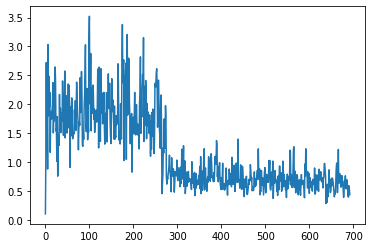

In [122]:
plt.plot(vig_ts)